In [40]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
import os
import time
import sklearn
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
from tabulate import tabulate
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import ExtraTreeClassifier
from sklearn.preprocessing import StandardScaler

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [42]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [43]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
            
    return files_add

files_add=find_the_way("../csvs",".csv")
files_add

['../csvs\\ack_maze.csv',
 '../csvs\\AmcrestCamBruteForce_1.pcap_Flow.csv',
 '../csvs\\BoT-IoT_OSScan.csv',
 '../csvs\\DDoS TCP SYN Flood Attacks-0001.pcap_Flow.csv',
 '../csvs\\dos-synflooding-1-dec.pcap_Flow.csv',
 '../csvs\\dos-synflooding-2-dec.pcap_Flow.csv',
 '../csvs\\dos-synflooding-3-dec.pcap_Flow.csv',
 '../csvs\\dos-synflooding-4-dec.pcap_Flow.csv',
 '../csvs\\dos-synflooding-5-dec.pcap_Flow.csv',
 '../csvs\\dos-synflooding-6-dec.pcap_Flow.csv',
 '../csvs\\Edge-IIoT.csv',
 '../csvs\\Edge-Port Scanning attack.pcap_Flow.csv',
 '../csvs\\edges-password attacks.pcap_Flow.csv',
 '../csvs\\GlobeLampUDPFlood_1.pcap_Flow.csv',
 '../csvs\\GosundRoombaHTTPFlood.csv',
 '../csvs\\http-flood -maze.csv',
 '../csvs\\mirai-ackflooding-1-dec.pcap_Flow.csv',
 '../csvs\\mirai-ackflooding-2-dec.pcap_Flow.csv',
 '../csvs\\mirai-ackflooding-3-dec.pcap_Flow.csv',
 '../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv',
 '../csvs\\mirai-hostbruteforce-1-dec.pcap_Flow.csv',
 '../csvs\\mirai-hostbruteforce

In [44]:
ml_list={"ET": ExtraTreeClassifier()}#,"SVC":SVC()}}

In [45]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [46]:
folder("results/compare/SS/")
folder("results/compare/CV/")
folder("results/compare/DD/")
folder("pdfs")

## Calculation of evaluations

In [47]:
def clean_data(X):
    # Convert to float to handle NaN values
    X = X.astype(np.float64)
    # Replace inf and -inf with NaN
    X[np.isinf(X)] = np.nan
    # Fill NaN with 0 or a specific value
    X = np.nan_to_num(X)
    return X


In [48]:
def score(train_time, test_time, predict, y_test, class_based_results, repeat, cv, dname, ml, sw):
    train_time = train_time[0]
    test_time = test_time[0]
    rc = sklearn.metrics.recall_score(y_test, predict, average="macro")
    pr = sklearn.metrics.precision_score(y_test, predict, average="macro")
    f_1 = sklearn.metrics.f1_score(y_test, predict, average="macro")
    accuracy = sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b = sklearn.metrics.balanced_accuracy_score(y_test, predict)
    kappa = sklearn.metrics.cohen_kappa_score(y_test, predict, labels=None, weights=None, sample_weight=None)
    
    try:
        roc = sklearn.metrics.roc_auc_score(y_test, predict)
    except ValueError:
        roc = 0  # Handle cases where ROC AUC cannot be computed
    
    # Define all possible classes (e.g., 0, 1 for binary classification)
    all_classes = sorted(np.unique(np.concatenate([y_test, predict])))
    target_names = [f"Class {cls}" for cls in all_classes]

    # Generate the classification report
    report = sklearn.metrics.classification_report(
        y_test,
        predict,
        target_names=target_names,
        labels=all_classes,  # Explicitly define the labels
        output_dict=True,
        zero_division=0,  # Handle cases with no support for a class
    )
    cr = pd.DataFrame(report).transpose()

    line = [dname, sw, repeat, cv, ml, accuracy, accuracy_b, pr, rc, f_1, kappa, roc, train_time, test_time]

    if class_based_results.empty:
        class_based_results = cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)

    return class_based_results, line


In [49]:
def ML(loop1, loop2, output_csv, cols, dname, sw):
    fold = 5
    repetition = 25
    for ii in ml_list:
        class_based_results = pd.DataFrame()
        cm = pd.DataFrame()
        cv = 0
        lines = [["Attack", "Feature", "T", "CV", "ML", "Acc", "b_Acc", "Prec", "Rec", "F1", "kap", "ROC", "tra-T", "test-T"]]
        
        for i in range(repetition):
            df = pd.read_csv(loop1, usecols=cols)
            df = df.fillna(0)
            X_train = np.array(df[df.columns[0:-1]])
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train = df[df.columns[-1]].cat.codes  

            df = pd.read_csv(loop2, usecols=cols)
            df = df.fillna(0)
            X_test = np.array(df[df.columns[0:-1]])
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test = df[df.columns[-1]].cat.codes  

            # Clean data
            X_train = clean_data(X_train)
            X_test = clean_data(X_test)

            # Scale data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            precision = []
            recall = []
            f1 = []
            accuracy = []
            train_time = []
            test_time = []
            total_time = []
            kappa = []
            accuracy_b = []

            # Machine learning algorithm
            clf = ml_list[ii]
            second = time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time() - second)))
            second = time.time()
            predict = clf.predict(X_test)
            test_time.append(float((time.time() - second)))

            class_based_results, line = score(train_time, test_time, predict, y_test, class_based_results, cv, i, dname, ii, sw)
            lines.append(line)

        results = pd.DataFrame(lines[1:], columns=lines[0])
        output_csv = output_csv.replace("./", "").replace("/", "-")
        results.to_csv(output_csv.replace("ML", ii), index=False)

        # Ensure only numeric columns are averaged
        results = results.select_dtypes(include=['number']).mean(numeric_only=True)
        results = results.round(3)
        
        return list(results.values)


In [50]:
def ML_CV(loop1,loop2,output_csv,cols,dname,sw):
    fold=3
    repetition=5
    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Attack","Feature","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)
            df = df.sample(frac=1).reset_index(drop=True)
            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  

                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )
    
                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)

        results = pd.DataFrame (lines[1:], columns = lines[0])
        output_csv=output_csv.replace("./","")
        output_csv=output_csv.replace("/","-")
        results.to_csv(output_csv.replace("ML",ii),index=False)

        results = results.select_dtypes(include=['number']).mean(numeric_only=True)
        results = results.round(3)
        #print (tabulate(results, headers=list(results.columns)))
        #print()
        return list(results.values)

In [51]:
features=[  'Src Port',  'Dst Port', 'Protocol',
  'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

In [52]:
len(features)

79

In [13]:
file_list={
'../csvs\\dos-synflooding-1-dec.pcap_Flow.csv':"SYN",
'../csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv':"HTTP",
'../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv':"ACK",
'../csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv':"UDP",
'../csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv':"ARP",
'../csvs\\scan-hostport-3-dec.pcap_Flow.csv':"SP",
'../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv':"BF",
'../csvs\\scan-portos-3-dec.pcap_Flow.csv':"OS",  
'../csvs\\scan-hostport-3-dec.pcap_Flow.csv':"SCHD",
'../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv':"MHDis"}

# CV

In [14]:
for train in (file_list):
    lines=[["Attack","Feature","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
    for dname in tqdm(features):

            target_names=["attack","benign"]
            feature=[dname, 'Label']
            output_csv=f".\\results\\compare\\CV\\ET_{file_list[train]}_{dname}.csv"
            #print(f"{list[train]} Dataset - Feature {number+1}/{len(features)}")
            temp=ML_CV(train,"",output_csv,feature,dname,file_list[train])
            temp=temp[2:]
            temp=[file_list[train],dname,"ET"]+temp
            lines.append(temp)

    results = pd.DataFrame (lines[1:], columns = lines[0])
    print (tabulate(results, headers=list(results.columns)))

100%|██████████| 79/79 [02:01<00:00,  1.53s/it]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN       Src Port           ET    1        0.97    0.977  0.97   0.972  0.944  0.97     0.003     0.001
 1  SYN       Dst Port           ET    1        0.997   1      0.997  0.999  0.997  0.997    0.003     0.001
 2  SYN       Protocol           ET    0.998    0.691   0.999  0.691  0.772  0.543  0.691    0.003     0.001
 3  SYN       Flow Duration      ET    0.998    0.794   0.872  0.794  0.818  0.636  0.794    0.004     0.004
 4  SYN       Tot Fwd Pkts       ET    0.998    0.693   0.967  0.693  0.764  0.528  0.693    0.004     0.001
 5  SYN       Tot Bwd Pkts       ET    0.999    0.888   0.845  0.888  0.864  0.727  0.888    0.002     0.001
 6  SYN       TotLen Fwd Pkts    ET    0.999    0.766   0.999  0.766  0.843  0.685  0.766    0.003     0.001
 7  SYN       TotLe

100%|██████████| 79/79 [00:43<00:00,  1.81it/s]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP      Src Port           ET    0.901    0.9     0.895  0.9    0.897  0.793  0.9      0.005     0
 1  HTTP      Dst Port           ET    0.964    0.954   0.972  0.954  0.961  0.923  0.954    0.001     0
 2  HTTP      Protocol           ET    0.676    0.587   0.826  0.587  0.542  0.203  0.587    0.001     0
 3  HTTP      Flow Duration      ET    0.754    0.74    0.742  0.74   0.741  0.482  0.74     0.002     0
 4  HTTP      Tot Fwd Pkts       ET    0.805    0.755   0.863  0.755  0.769  0.555  0.755    0.001     0
 5  HTTP      Tot Bwd Pkts       ET    0.827    0.779   0.889  0.779  0.795  0.605  0.779    0.001     0
 6  HTTP      TotLen Fwd Pkts    ET    0.816    0.766   0.882  0.766  0.781  0.58   0.766    0.001     0
 7  HTTP      TotLen Bwd Pkts    ET    0.817   

100%|██████████| 79/79 [00:36<00:00,  2.18it/s]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ACK       Src Port           ET    0.818    0.805   0.816  0.805  0.809   0.618  0.805    0.002     0
 1  ACK       Dst Port           ET    0.999    0.999   0.999  0.999  0.999   0.999  0.999    0.001     0
 2  ACK       Protocol           ET    0.59     0.5     0.295  0.5    0.371   0      0.5      0.001     0
 3  ACK       Flow Duration      ET    0.739    0.731   0.731  0.731  0.73    0.461  0.731    0.001     0
 4  ACK       Tot Fwd Pkts       ET    0.825    0.842   0.833  0.842  0.825   0.655  0.842    0.001     0
 5  ACK       Tot Bwd Pkts       ET    0.739    0.779   0.805  0.779  0.737   0.508  0.779    0.001     0
 6  ACK       TotLen Fwd Pkts    ET    0.727    0.768   0.8    0.768  0.724   0.488  0.768    0.001     0
 7  ACK       TotLen Bwd Pkts    ET   

100%|██████████| 79/79 [00:34<00:00,  2.26it/s]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP       Src Port           ET    0.987    0.911   0.879  0.911  0.875  0.751  0.911    0.001     0
 1  UDP       Dst Port           ET    0.999    1       0.993  1      0.996  0.992  1        0.001     0
 2  UDP       Protocol           ET    0.973    0.5     0.487  0.5    0.493  0      0.5      0.001     0
 3  UDP       Flow Duration      ET    0.992    0.943   0.941  0.943  0.934  0.868  0.943    0.001     0
 4  UDP       Tot Fwd Pkts       ET    0.998    0.999   0.959  0.999  0.976  0.952  0.999    0.001     0
 5  UDP       Tot Bwd Pkts       ET    0.973    0.5     0.487  0.5    0.493  0      0.5      0.001     0
 6  UDP       TotLen Fwd Pkts    ET    0.985    0.895   0.835  0.895  0.854  0.708  0.895    0.002     0
 7  UDP       TotLen Bwd Pkts    ET    0.997   

100%|██████████| 79/79 [00:31<00:00,  2.47it/s]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ARP       Src Port           ET        1        1       1      1     1    nan      0    0.001         0
 1  ARP       Dst Port           ET        1        1       1      1     1    nan      0    0.001         0
 2  ARP       Protocol           ET        1        1       1      1     1    nan      0    0.001         0
 3  ARP       Flow Duration      ET        1        1       1      1     1    nan      0    0.001         0
 4  ARP       Tot Fwd Pkts       ET        1        1       1      1     1    nan      0    0.001         0
 5  ARP       Tot Bwd Pkts       ET        1        1       1      1     1    nan      0    0.001         0
 6  ARP       TotLen Fwd Pkts    ET        1        1       1      1     1    nan      0    0.001         0
 7  ARP       TotLen Bwd Pkt

100%|██████████| 79/79 [00:35<00:00,  2.22it/s]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD      Src Port           ET    1        0.998   1      0.998  0.999  0.997  0.998    0.001     0.001
 1  SCHD      Dst Port           ET    0.965    0.896   0.821  0.896  0.852  0.705  0.896    0.001     0
 2  SCHD      Protocol           ET    0.963    0.687   0.981  0.687  0.76   0.524  0.687    0.001     0
 3  SCHD      Flow Duration      ET    0.984    0.925   0.932  0.925  0.925  0.851  0.925    0.001     0.001
 4  SCHD      Tot Fwd Pkts       ET    0.965    0.709   0.951  0.709  0.778  0.559  0.709    0.001     0
 5  SCHD      Tot Bwd Pkts       ET    0.976    0.862   0.911  0.862  0.882  0.764  0.862    0.002     0
 6  SCHD      TotLen Fwd Pkts    ET    0.966    0.702   0.982  0.702  0.775  0.554  0.702    0.001     0
 7  SCHD      TotLen Bwd Pkts    ET    

100%|██████████| 79/79 [00:38<00:00,  2.04it/s]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  BF        Src Port           ET    0.991    0.983   0.984  0.983  0.983   0.967  0.983    0.001     0
 1  BF        Dst Port           ET    0.96     0.881   0.963  0.881  0.916   0.832  0.881    0.001     0
 2  BF        Protocol           ET    0.849    0.5     0.424  0.5    0.459   0      0.5      0.001     0
 3  BF        Flow Duration      ET    0.839    0.667   0.684  0.667  0.673   0.348  0.667    0.001     0
 4  BF        Tot Fwd Pkts       ET    0.854    0.57    0.717  0.57   0.585   0.198  0.57     0.001     0
 5  BF        Tot Bwd Pkts       ET    0.865    0.627   0.752  0.627  0.656   0.325  0.627    0.001     0
 6  BF        TotLen Fwd Pkts    ET    0.878    0.671   0.79   0.671  0.706   0.419  0.671    0.002     0
 7  BF        TotLen Bwd Pkts    ET   

100%|██████████| 79/79 [00:35<00:00,  2.22it/s]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS        Src Port           ET    0.997    0.988   0.998  0.988  0.993  0.985  0.988    0.001         0
 1  OS        Dst Port           ET    0.959    0.924   0.89   0.924  0.905  0.809  0.924    0.001         0
 2  OS        Protocol           ET    0.93     0.704   0.963  0.704  0.77   0.548  0.704    0.001         0
 3  OS        Flow Duration      ET    0.934    0.841   0.84   0.841  0.839  0.679  0.841    0.001         0
 4  OS        Tot Fwd Pkts       ET    0.907    0.65    0.84   0.65   0.693  0.397  0.65     0.001         0
 5  OS        Tot Bwd Pkts       ET    0.941    0.815   0.884  0.815  0.844  0.689  0.815    0.001         0
 6  OS        TotLen Fwd Pkts    ET    0.91     0.653   0.871  0.653  0.699  0.41   0.653    0.001         0
 7  OS        TotLe

100%|██████████| 79/79 [00:37<00:00,  2.11it/s]

    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  MHDis     Src Port           ET    0.995    0.992   0.99   0.992  0.991   0.982  0.992    0.001     0
 1  MHDis     Dst Port           ET    0.972    0.915   0.976  0.915  0.942   0.884  0.915    0.001     0
 2  MHDis     Protocol           ET    0.846    0.5     0.423  0.5    0.458   0      0.5      0.001     0
 3  MHDis     Flow Duration      ET    0.807    0.606   0.618  0.606  0.611   0.222  0.606    0.001     0
 4  MHDis     Tot Fwd Pkts       ET    0.858    0.576   0.755  0.576  0.594   0.217  0.576    0.001     0
 5  MHDis     Tot Bwd Pkts       ET    0.852    0.58    0.717  0.58   0.597   0.217  0.58     0.001     0
 6  MHDis     TotLen Fwd Pkts    ET    0.868    0.619   0.788  0.619  0.651   0.319  0.619    0.001     0
 7  MHDis     TotLen Bwd Pkts    ET   

# Session vs Session

In [56]:
file_list_session={
"SYN":[ '../csvs\\dos-synflooding-1-dec.pcap_Flow.csv', '../csvs\\dos-synflooding-2-dec.pcap_Flow.csv',],
"HTTP":['../csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv', '../csvs\\mirai-httpflooding-1-dec.pcap_Flow.csv'],
"ACK":['../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv','../csvs\\mirai-ackflooding-1-dec.pcap_Flow.csv'],
"UDP":[ '../csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv','../csvs\\mirai-udpflooding-1-dec.pcap_Flow.csv'],
"ARP":[ '../csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv', '../csvs\\mitm-arpspoofing-4-dec.pcap_Flow.csv'],
"SP":['../csvs\\scan-hostport-3-dec.pcap_Flow.csv','../csvs\\scan-hostport-4-dec.pcap_Flow.csv'],
"BF":[ '../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv','../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv'],
"OS":['../csvs\\scan-portos-3-dec.pcap_Flow.csv','../csvs\\scan-portos-6-dec.pcap_Flow.csv'],
"SCHD":['../csvs\\scan-hostport-3-dec.pcap_Flow.csv','../csvs\\scan-hostport-4-dec.pcap_Flow.csv'],
"MHDis":['../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv','../csvs\\mirai-hostbruteforce-2-dec.pcap_Flow.csv']}

In [ ]:
for train in (file_list_session):
    lines=[["Attack","Feature","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
    for dname in tqdm(features):
            target_names=["attack","benign"]
            feature=[dname, 'Label']
            
            output_csv=f".\\results\\compare\\SS\\ET_{train}_{dname}.csv"
            temp=ML(file_list_session[train][0],file_list_session[train][1],output_csv,feature,dname,train)  
            temp=temp[2:]
            temp=[train,dname,"ET"]+temp
            lines.append(temp)

    results = pd.DataFrame (lines[1:], columns = lines[0])
    print (tabulate(results, headers=list(results.columns)))

  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [12:14<00:00,  9.30s/it]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN       Src Port           ET    1        0.977   0.994  0.977  0.985  0.971  0.977    0.004     0.003
 1  SYN       Dst Port           ET    1        0.992   1      0.992  0.996  0.992  0.992    0.004     0.002
 2  SYN       Protocol           ET    0.996    0.687   0.998  0.687  0.771  0.543  0.687    0.004     0.001
 3  SYN       Flow Duration      ET    0.996    0.768   0.865  0.768  0.808  0.617  0.768    0.017     0.002
 4  SYN       Tot Fwd Pkts       ET    0.996    0.665   0.998  0.665  0.747  0.494  0.665    0.003     0.001
 5  SYN       Tot Bwd Pkts       ET    0.997    0.854   0.879  0.854  0.866  0.732  0.854    0.004     0.001
 6  SYN       TotLen Fwd Pkts    ET    0.997    0.736   0.998  0.736  0.82   0.64   0.736    0.003     0.001
 7  SYN       TotLe

100%|██████████| 79/79 [03:27<00:00,  2.62s/it]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  HTTP      Src Port           ET    0.34     0.392   0.188  0.392  0.254  -0.192  0.392    0.003     0.001
 1  HTTP      Dst Port           ET    0.961    0.955   0.968  0.955  0.96    0.92   0.955    0.002     0.001
 2  HTTP      Protocol           ET    0.669    0.618   0.815  0.618  0.578   0.259  0.618    0.001     0
 3  HTTP      Flow Duration      ET    0.473    0.498   0.498  0.498  0.465  -0.003  0.498    0.004     0
 4  HTTP      Tot Fwd Pkts       ET    0.715    0.672   0.833  0.672  0.656   0.373  0.672    0.003     0
 5  HTTP      Tot Bwd Pkts       ET    0.707    0.662   0.83   0.662  0.642   0.353  0.662    0.002     0.001
 6  HTTP      TotLen Fwd Pkts    ET    0.796    0.765   0.868  0.765  0.77    0.561  0.765    0.003     0.001
 7  HTTP      TotLen B

100%|██████████| 79/79 [05:49<00:00,  4.42s/it]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ACK       Src Port           ET    0.677    0.682   0.518  0.682  0.445   0.047  0.682    0.002     0.002
 1  ACK       Dst Port           ET    0.022    0.5     0.011  0.5    0.022   0      0.5      0.002     0.001
 2  ACK       Protocol           ET    0.022    0.5     0.011  0.5    0.022   0      0.5      0.001     0.001
 3  ACK       Flow Duration      ET    0.766    0.778   0.533  0.778  0.498   0.094  0.778    0.004     0.002
 4  ACK       Tot Fwd Pkts       ET    0.207    0.434   0.491  0.434  0.181  -0.007  0.434    0.005     0.002
 5  ACK       Tot Bwd Pkts       ET    0.985    0.661   0.992  0.661  0.74    0.482  0.661    0.002     0.001
 6  ACK       TotLen Fwd Pkts    ET    0.99     0.769   0.989  0.769  0.846   0.692  0.769    0.002     0.001
 7  ACK   

100%|██████████| 79/79 [02:46<00:00,  2.11s/it]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  UDP       Src Port           ET    0.858    0.88    0.886  0.88   0.854   0.732  0.88     0.003     0.001
 1  UDP       Dst Port           ET    0.406    0.5     0.203  0.5    0.289   0      0.5      0.002     0
 2  UDP       Protocol           ET    0.406    0.5     0.203  0.5    0.289   0      0.5      0.002     0
 3  UDP       Flow Duration      ET    0.401    0.494   0.201  0.494  0.286  -0.01   0.494    0.002     0
 4  UDP       Tot Fwd Pkts       ET    0.406    0.5     0.203  0.5    0.289   0      0.5      0.002     0
 5  UDP       Tot Bwd Pkts       ET    0.406    0.5     0.203  0.5    0.289   0      0.5      0.002     0
 6  UDP       TotLen Fwd Pkts    ET    0.42     0.511   0.519  0.511  0.32    0.018  0.511    0.002     0
 7  UDP       TotLen Bwd Pkts    E

100%|██████████| 79/79 [02:47<00:00,  2.12s/it]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ARP       Src Port           ET        1        1       1      1     1    nan      0    0.002     0
 1  ARP       Dst Port           ET        1        1       1      1     1    nan      0    0.002     0
 2  ARP       Protocol           ET        1        1       1      1     1    nan      0    0.001     0
 3  ARP       Flow Duration      ET        1        1       1      1     1    nan      0    0.002     0
 4  ARP       Tot Fwd Pkts       ET        1        1       1      1     1    nan      0    0.002     0
 5  ARP       Tot Bwd Pkts       ET        1        1       1      1     1    nan      0    0.001     0
 6  ARP       TotLen Fwd Pkts    ET        1        1       1      1     1    nan      0    0.002     0.001
 7  ARP       TotLen Bwd Pkts    ET        1        

100%|██████████| 79/79 [02:39<00:00,  2.02s/it]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  SP        Src Port           ET    0.09     0.48    0.045  0.48   0.083  -0.007  0.48     0.002     0
 1  SP        Dst Port           ET    0.962    0.828   0.933  0.828  0.872   0.744  0.828    0.002     0
 2  SP        Protocol           ET    0.938    0.67    0.968  0.67   0.737   0.483  0.67     0.002     0
 3  SP        Flow Duration      ET    0.891    0.861   0.718  0.861  0.762   0.53   0.861    0.002     0.003
 4  SP        Tot Fwd Pkts       ET    0.926    0.707   0.803  0.707  0.743   0.488  0.707    0.002     0
 5  SP        Tot Bwd Pkts       ET    0.931    0.796   0.796  0.796  0.796   0.593  0.796    0.003     0
 6  SP        TotLen Fwd Pkts    ET    0.954    0.752   0.976  0.752  0.823   0.649  0.752    0.001     0.001
 7  SP        TotLen Bwd Pkts 

100%|██████████| 79/79 [02:47<00:00,  2.12s/it]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  BF        Src Port           ET    0.976    0.945   0.96   0.945  0.952   0.905  0.945    0.002     0.002
 1  BF        Dst Port           ET    0.919    0.739   0.954  0.739  0.8     0.606  0.739    0.002     0
 2  BF        Protocol           ET    0.846    0.5     0.423  0.5    0.458   0      0.5      0.002     0.001
 3  BF        Flow Duration      ET    0.821    0.624   0.644  0.624  0.632   0.266  0.624    0.005     0.001
 4  BF        Tot Fwd Pkts       ET    0.859    0.569   0.779  0.569  0.584   0.203  0.569    0.001     0
 5  BF        Tot Bwd Pkts       ET    0.856    0.594   0.727  0.594  0.618   0.254  0.594    0.002     0
 6  BF        TotLen Fwd Pkts    ET    0.848    0.612   0.695  0.612  0.634   0.277  0.612    0.002     0
 7  BF        TotLen Bwd P

100%|██████████| 79/79 [03:38<00:00,  2.77s/it]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS        Src Port           ET    0.334    0.632   0.498  0.632  0.276  0.023  0.632    0.002     0.001
 1  OS        Dst Port           ET    0.984    0.848   0.864  0.848  0.856  0.712  0.848    0.001     0.001
 2  OS        Protocol           ET    0.975    0.608   0.905  0.608  0.666  0.337  0.608    0.001     0
 3  OS        Flow Duration      ET    0.786    0.713   0.537  0.713  0.515  0.106  0.713    0.002     0.001
 4  OS        Tot Fwd Pkts       ET    0.98     0.679   0.962  0.679  0.755  0.512  0.679    0.002     0
 5  OS        Tot Bwd Pkts       ET    0.986    0.872   0.884  0.872  0.878  0.755  0.872    0.002     0.001
 6  OS        TotLen Fwd Pkts    ET    0.98     0.664   0.973  0.664  0.739  0.48   0.664    0.002     0.001
 7  OS        TotLen Bwd Pk

 95%|█████████▍| 75/79 [03:49<00:10,  2.58s/it]

# Dataset vs Dataset

In [ ]:
file_list_dataset={
"SYN":[ '../csvs\\dos-synflooding-1-dec.pcap_Flow.csv', '../csvs\\dos-synflooding-6-dec.pcap_Flow.csv',],
"HTTP":['../csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv', '../csvs\\http-flood -maze.csv'],
"ACK":['../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv','../csvs\\ack_maze.csv'],
"UDP":[ '../csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv','../csvs\\UDP_DDoS_00001.pcap_Flow.csv'],
"ARP":[ '../csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv', '../csvs\\mitm-arpspoofing-5-dec.pcap_Flow.csv'],
"SP":['../csvs\\scan-hostport-3-dec.pcap_Flow.csv','../csvs\\Edge-Port Scanning attack.pcap_Flow.csv'],
"BF":[ '../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv','../csvs\\edges-password attacks.pcap_Flow.csv'],
"OS":['../csvs\\scan-portos-3-dec.pcap_Flow.csv','../csvs\\BoT-IoT_OSScan.csv'],
"SCHD":['../csvs\\scan-hostport-3-dec.pcap_Flow.csv','../csvs\\scan-hostport-5-dec.pcap_Flow.csv'],
"MHDis":['../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv','../csvs\\mirai-hostbruteforce-4-dec.pcap_Flow.csv']}

In [ ]:
for train in (file_list_dataset):
    lines=[["Attack","Feature","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
    for dname in tqdm(features):
        target_names=["attack","benign"]
        feature=[dname, 'Label']
        
        output_csv=f".\\results\\compare\\DD\\ET_{train}_{dname}.csv"
        temp=ML(file_list_dataset[train][0],file_list_dataset[train][1],output_csv,feature,dname,train)  
        temp=temp[2:]
        temp=[train,dname,"ET"]+temp
        lines.append(temp)

    results = pd.DataFrame (lines[1:], columns = lines[0])
    print (tabulate(results, headers=list(results.columns)))

100%|██████████| 79/79 [18:05<00:00, 13.74s/it]


    Attack    Feature            ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  OS        Src Port           ET    0.116    0.471   0.474  0.471  0.115  -0.007  0.471    0.008     0.011
 1  OS        Dst Port           ET    0.96     0.756   0.819  0.756  0.784   0.568  0.756    0.003     0.007
 2  OS        Protocol           ET    0.96     0.639   0.98   0.639  0.707   0.42   0.639    0.002     0.003
 3  OS        Flow Duration      ET    0.431    0.502   0.5    0.502  0.342   0.001  0.502    0.004     0.01
 4  OS        Tot Fwd Pkts       ET    0.948    0.531   0.878  0.531  0.545   0.11   0.531    0.005     0.005
 5  OS        Tot Bwd Pkts       ET    0.97     0.782   0.898  0.782  0.829   0.658  0.782    0.003     0.006
 6  OS        TotLen Fwd Pkts    ET    0.947    0.536   0.802  0.536  0.553   0.124  0.536    0.002     0.004
 7  OS     

 34%|███▍      | 27/79 [01:25<02:43,  3.15s/it]


KeyboardInterrupt: 

In [ ]:
folders=["CV","SS","DD"]

In [ ]:
results = [['Attack', 'Feature', "Folder", 'T', 'CV', 'Acc', 'b_Acc', 'Prec', 'Rec',
            'F1', 'kap', 'ROC', 'tra-T', 'test-T']]

for f in ["CV", "SS", "DD"]:
    files_add = find_the_way(f".\\results\\compare\\{f}", ".csv")
    for i in tqdm(files_add):
        df = pd.read_csv(i)
        temp = df.values  # Capture original data for first two columns
        df_numeric = df.select_dtypes(include=['number']).mean()  # Calculate mean of numeric columns
        df_mean_values = df_numeric.values.tolist()  # Convert to list
        temp_row = list(temp[0][:2])  # Extract first two elements
        temp_row.append(f)  # Add folder name
        temp_row += df_mean_values  # Add calculated mean values
        results.append(temp_row)

# Create DataFrame from results
results = pd.DataFrame(results[1:], columns=results[0])


100%|██████████| 553/553 [00:14<00:00, 38.34it/s]


In [ ]:
results.columns

Index(['Attack', 'Feature', 'Folder', 'T', 'CV', 'Acc', 'b_Acc', 'Prec', 'Rec',
       'F1', 'kap', 'ROC', 'tra-T', 'test-T'],
      dtype='object')

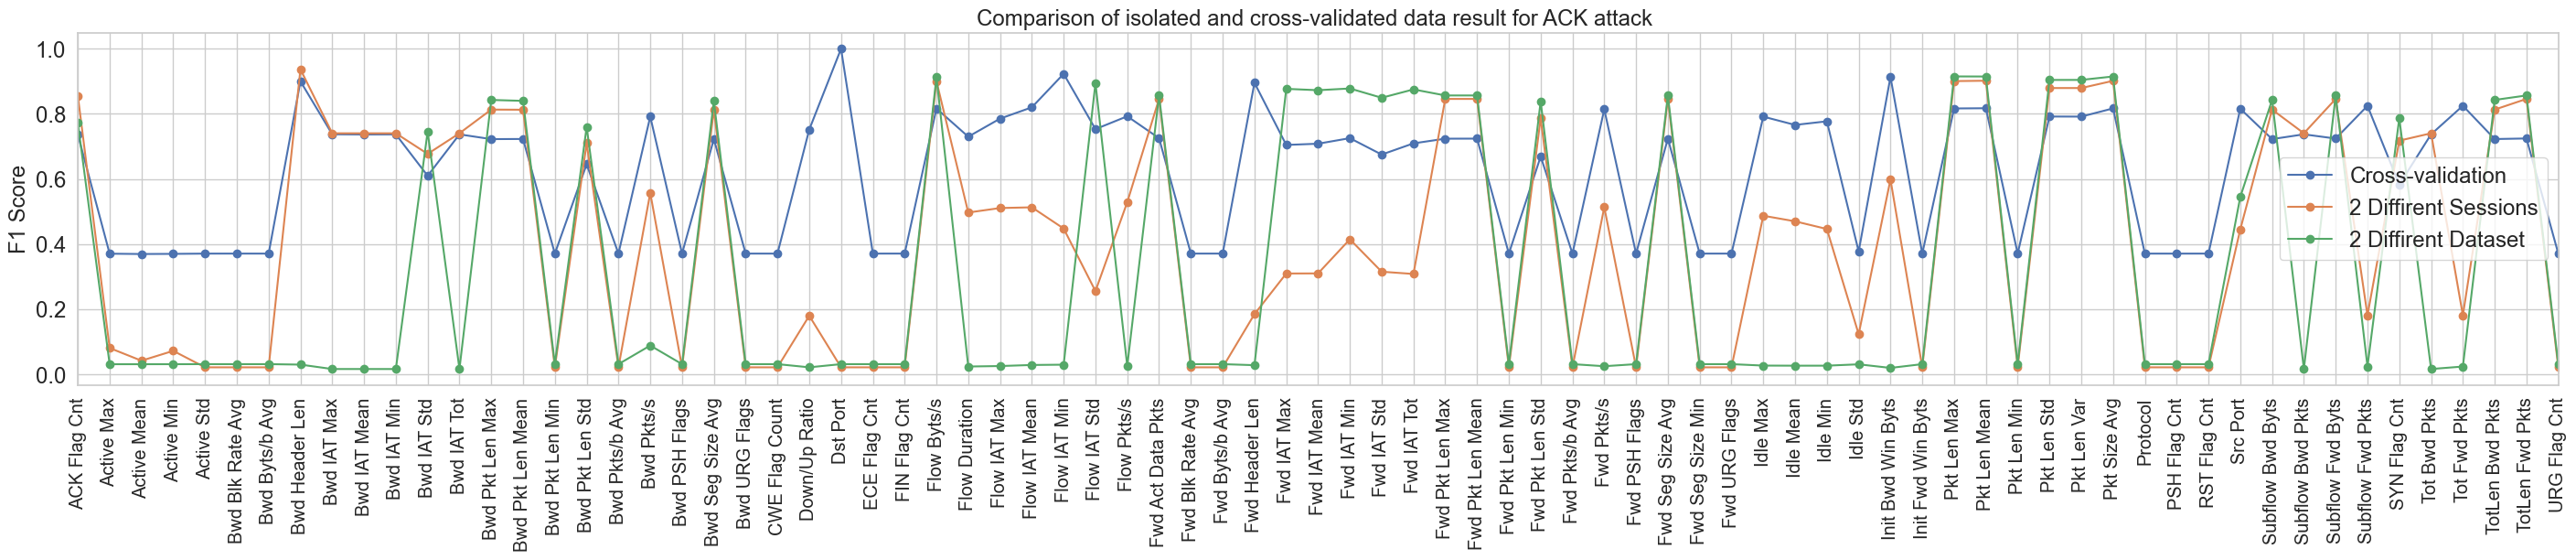

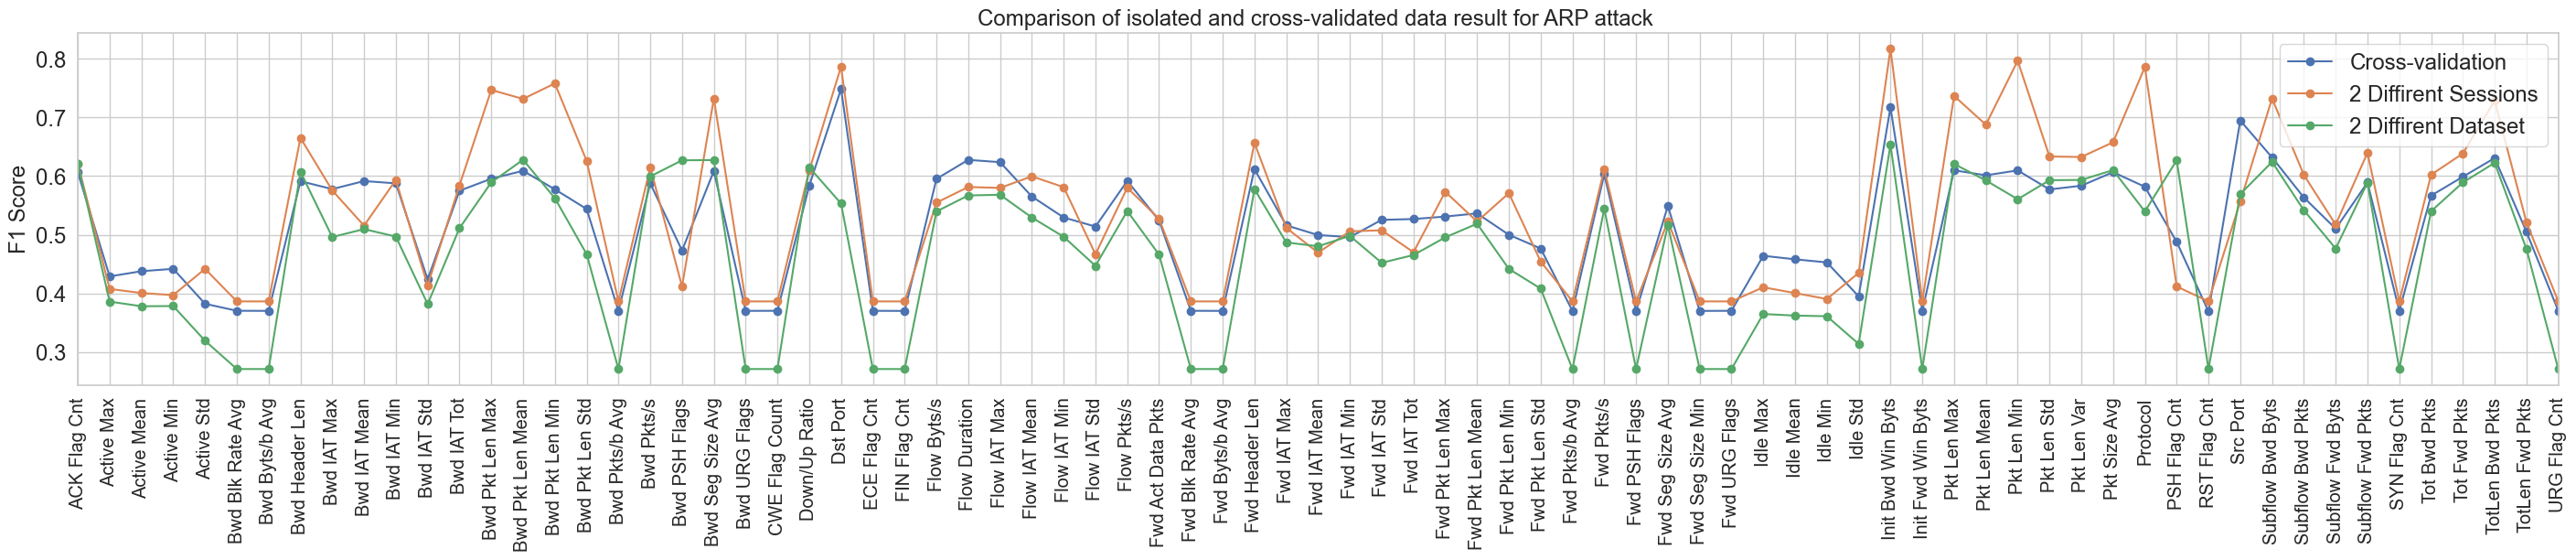

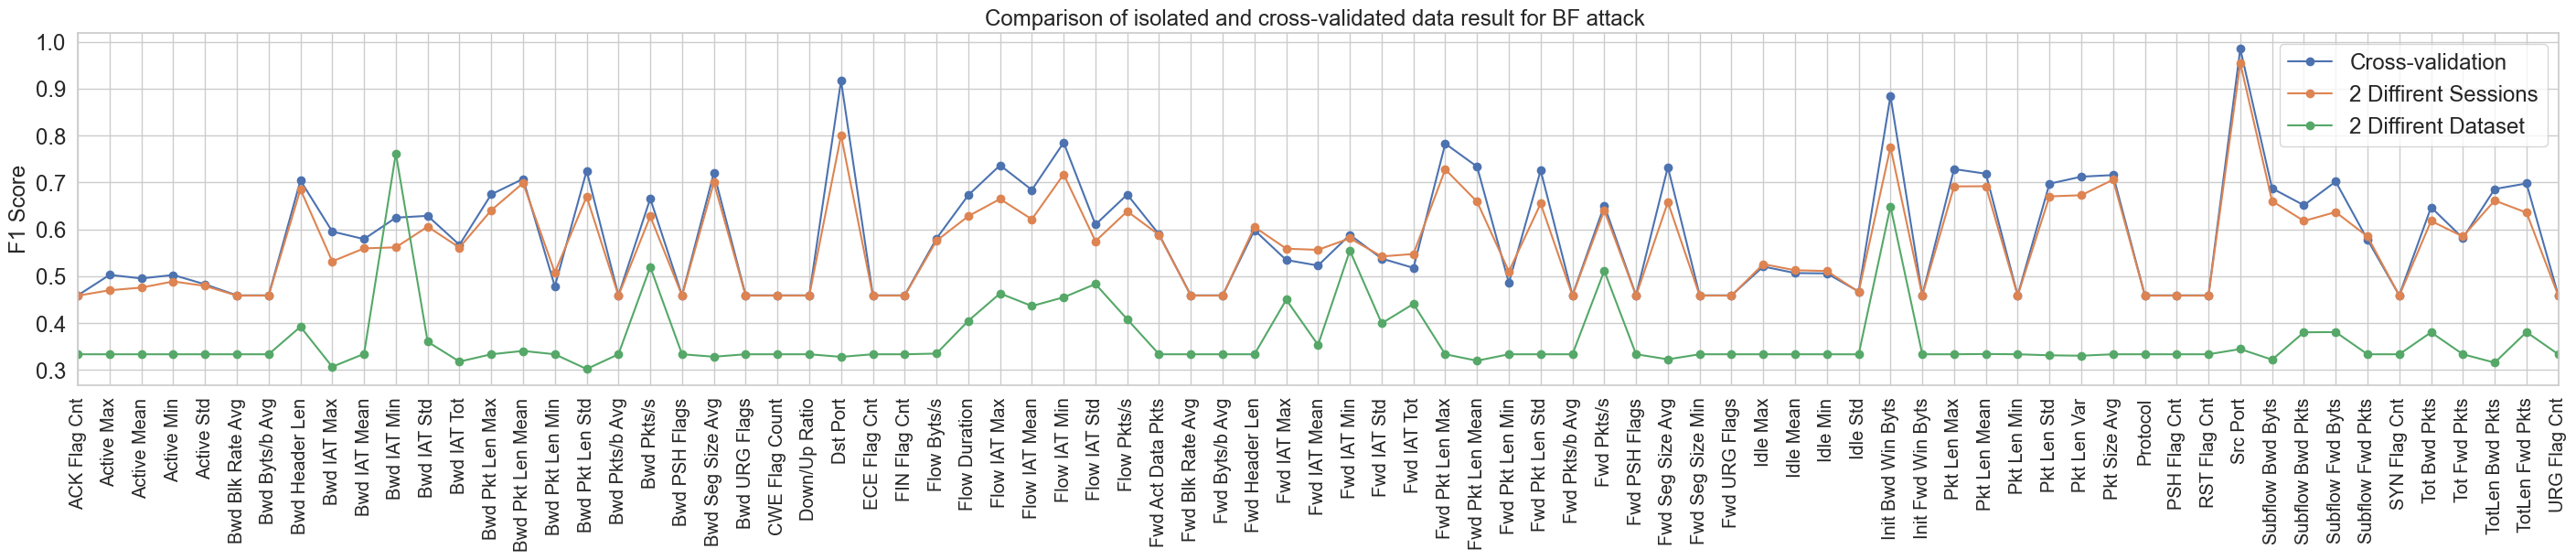

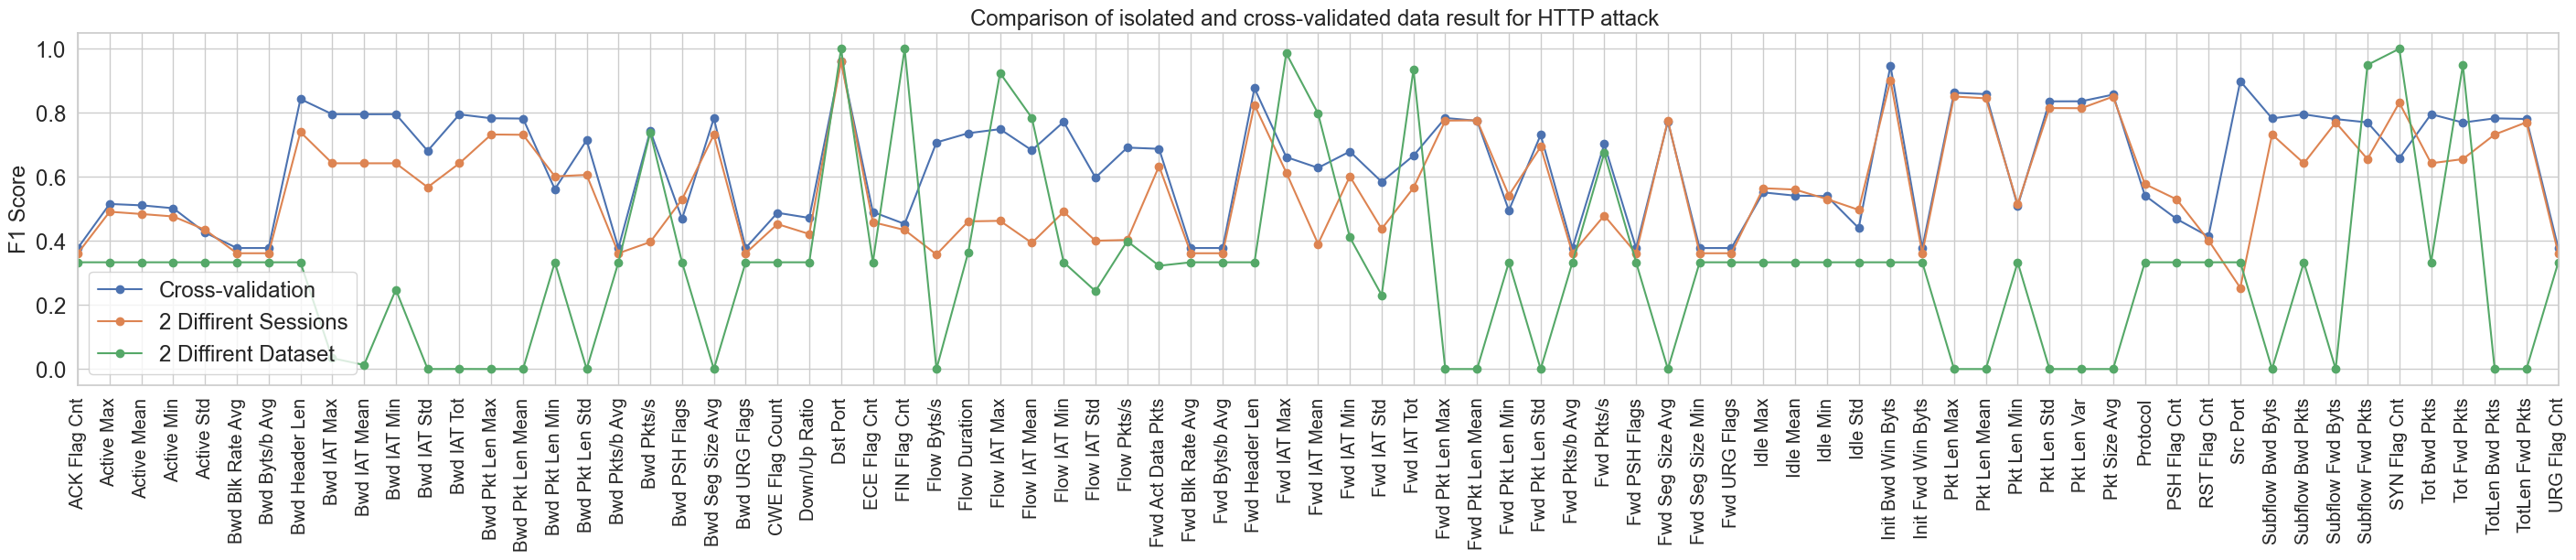

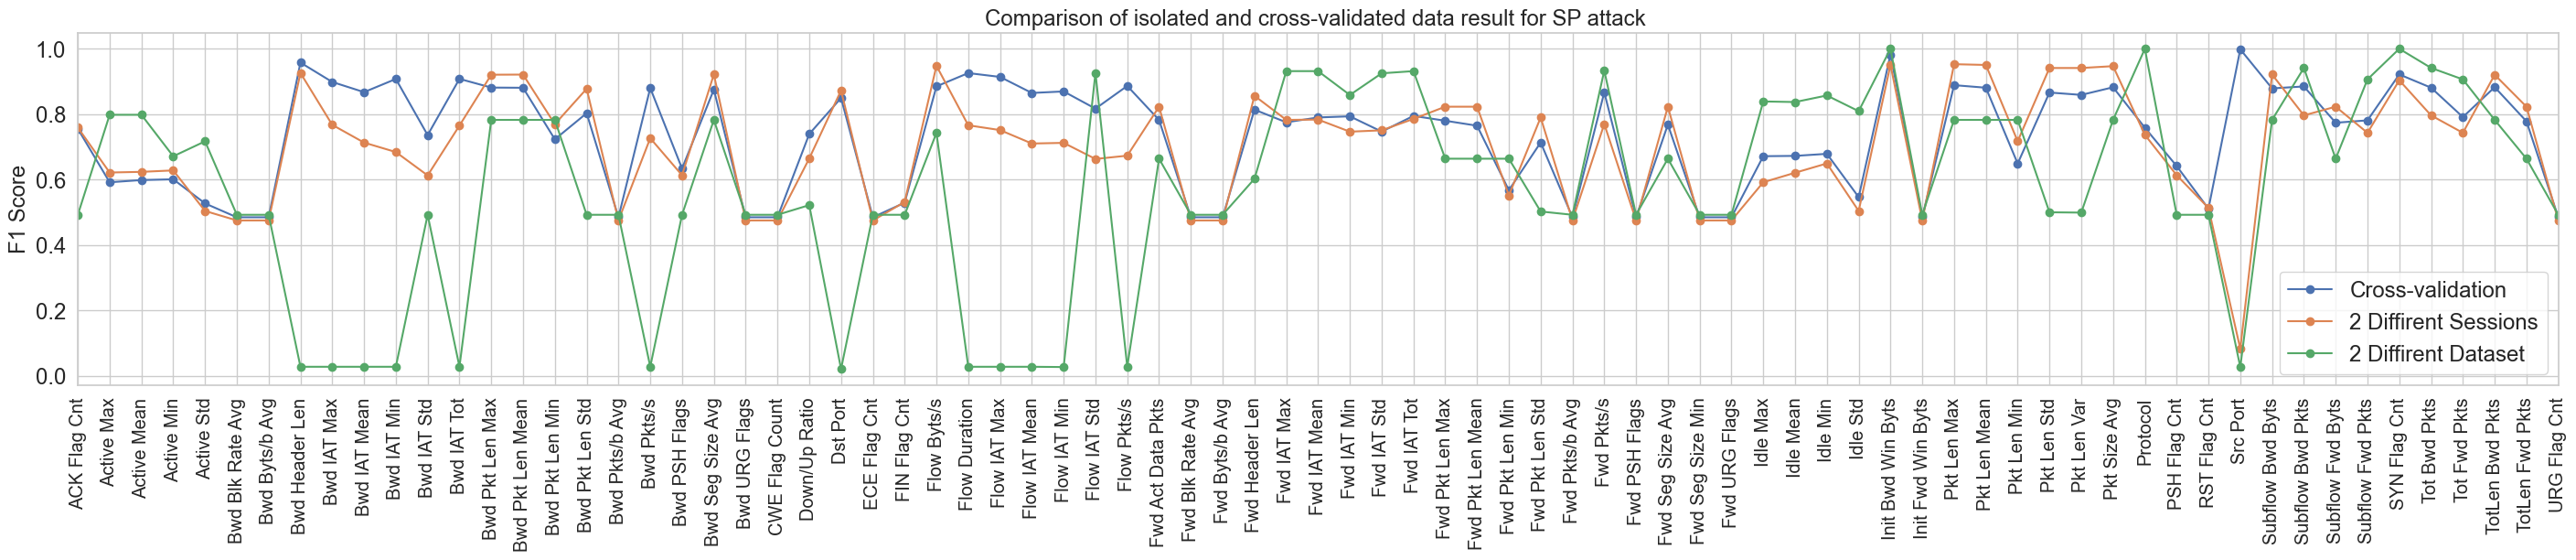

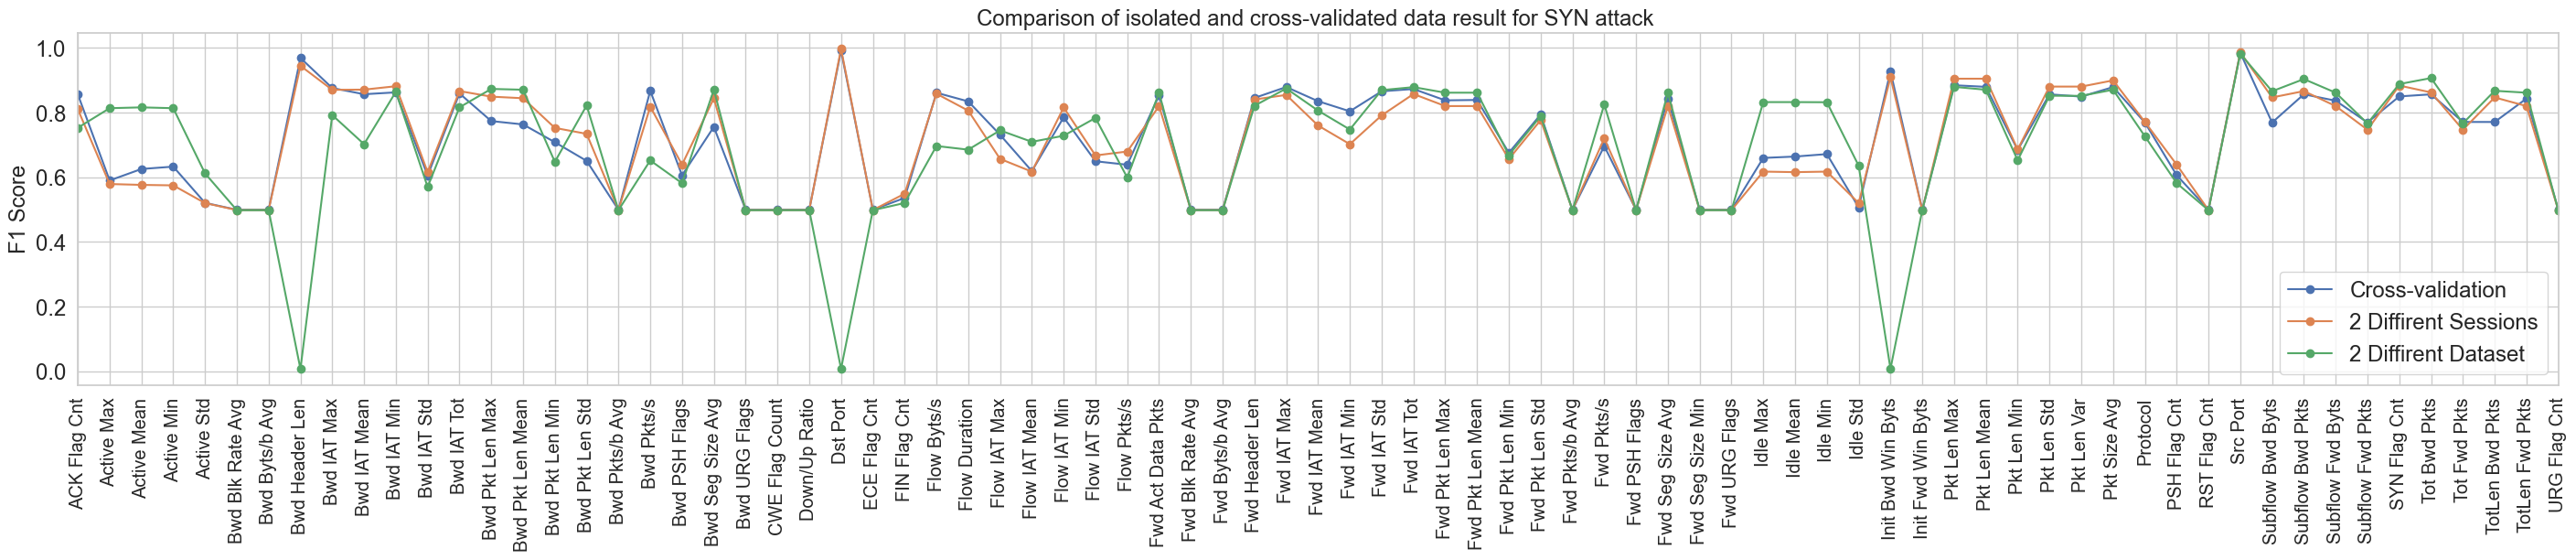

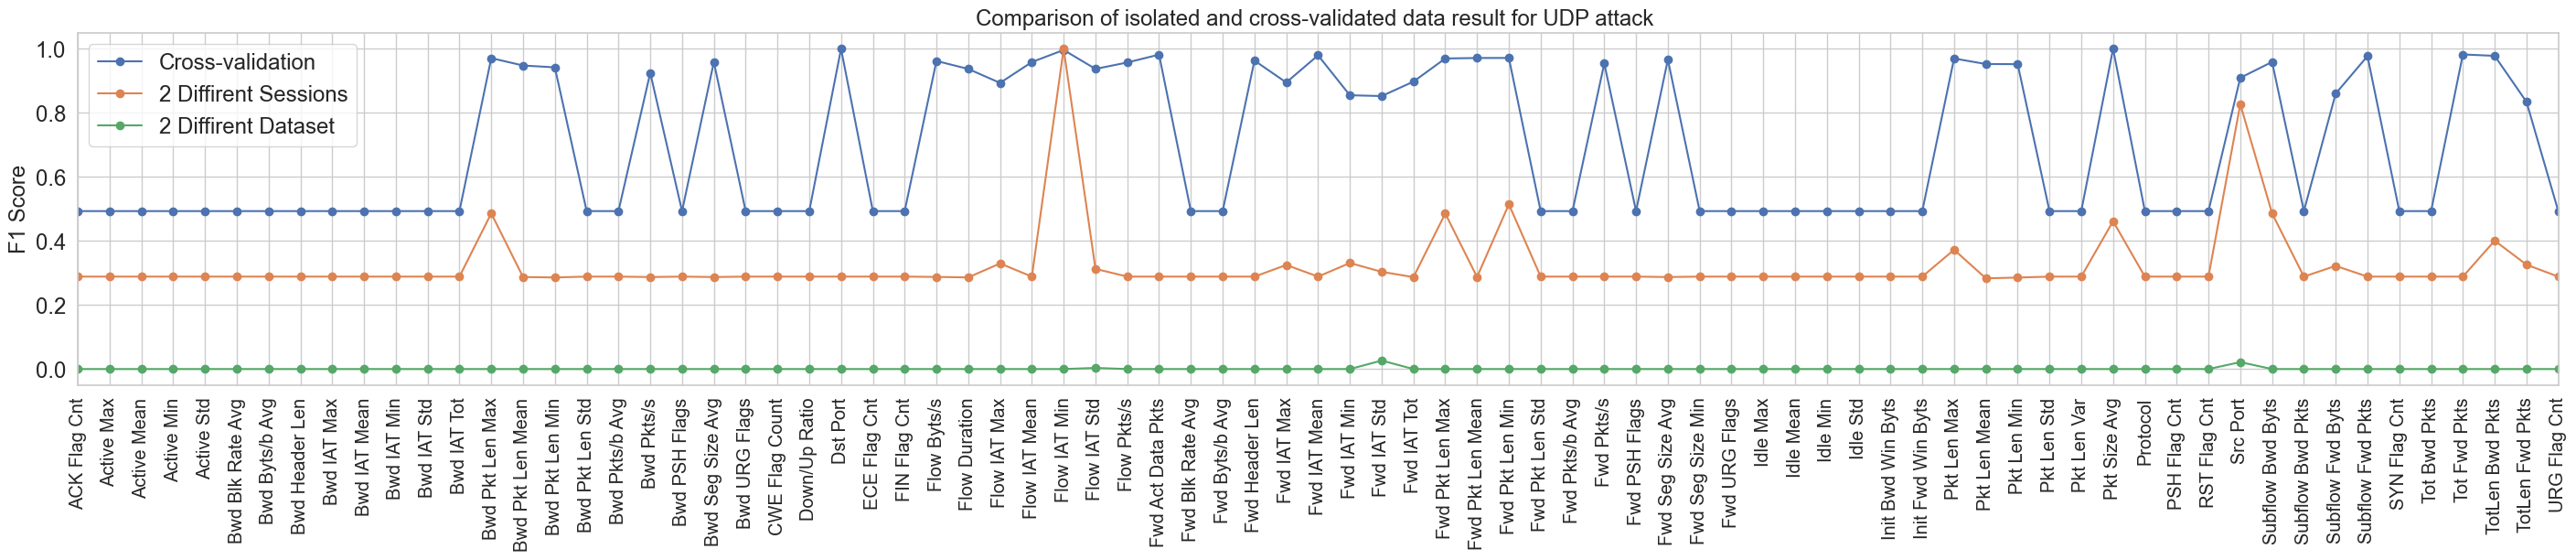

In [ ]:
method={"CV":"Cross-validation","SS":"2 Diffirent Sessions","DD":"2 Diffirent Dataset" }
import matplotlib.pylab as pylab
sns.set_style("whitegrid")
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (35, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'x-large'}
for i in results["Feature"].unique():    
    graph_name=f"./pdfs/Comparison_f1_{i}.pdf"
    plt.margins(x=0)
    
    df=results[results["Feature"]==i]
    for ii in results["Folder"].unique():
        sf=df[df["Folder"]==ii]
        my_xticks=sf["Attack"]#list(iso.index)
        pylab.rcParams.update(params)
        #plt.figure(figsize=(10,10))
        #plt.plot(my_xticks,iso['Acc'], linestyle='--', marker='.', color='b',label= "Separate Train & Test acc")
        #plt.plot(my_xticks,cv['Acc'], linestyle='--', marker='.', color='r',label= "10-Fold CV acc")
        plt.plot(my_xticks,sf['F1'], linestyle='-', marker='o',label= method[ii])
    #plt.plot(my_xticks,iso[' F1-score'], linestyle='-', marker='o', color='m',label= "Diffirent Dataset Isolated")
    #plt.plot(my_xticks,cv[' F1-score'], linestyle='-', marker='o', color='b',label= "5-Fold CV")
    #plt.axhline(0.492885, color='r',label= "Primary feature list")
    #plt.axhline(0.443367, color='r',label= "Primary feature list")
    plt.title(f"Comparison of isolated and cross-validated data result for {i} attack ")
    plt.legend(numpoints=1)
    #plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.ylabel("F1 Score")
    plt.xticks(rotation=90) 
    #plt.ylim([0.69, 0.71]) 
    plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)
    plt.show()

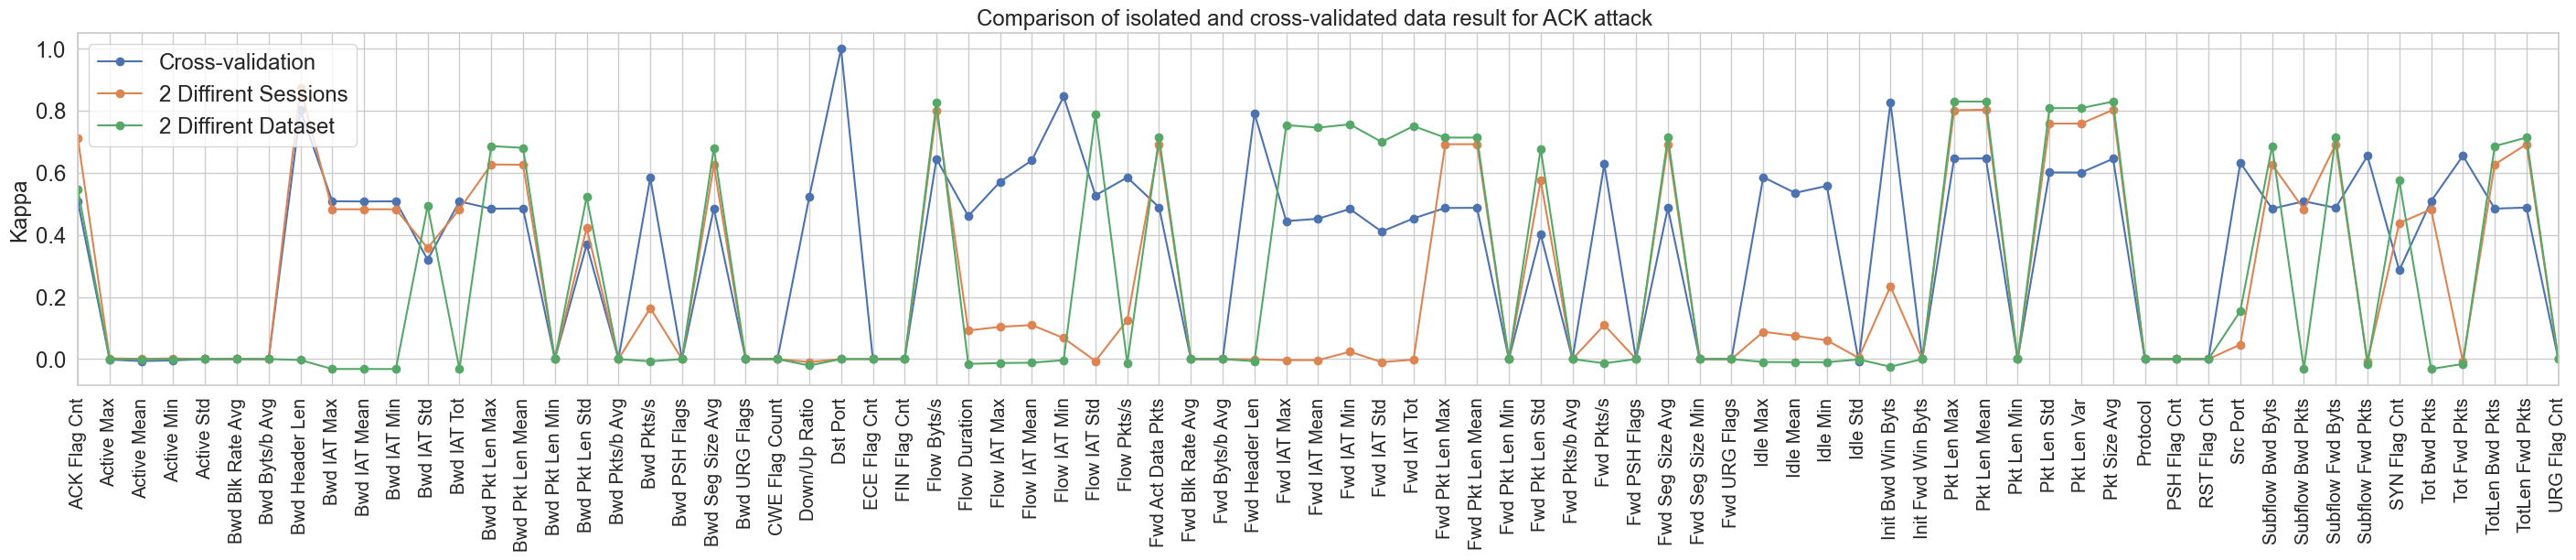

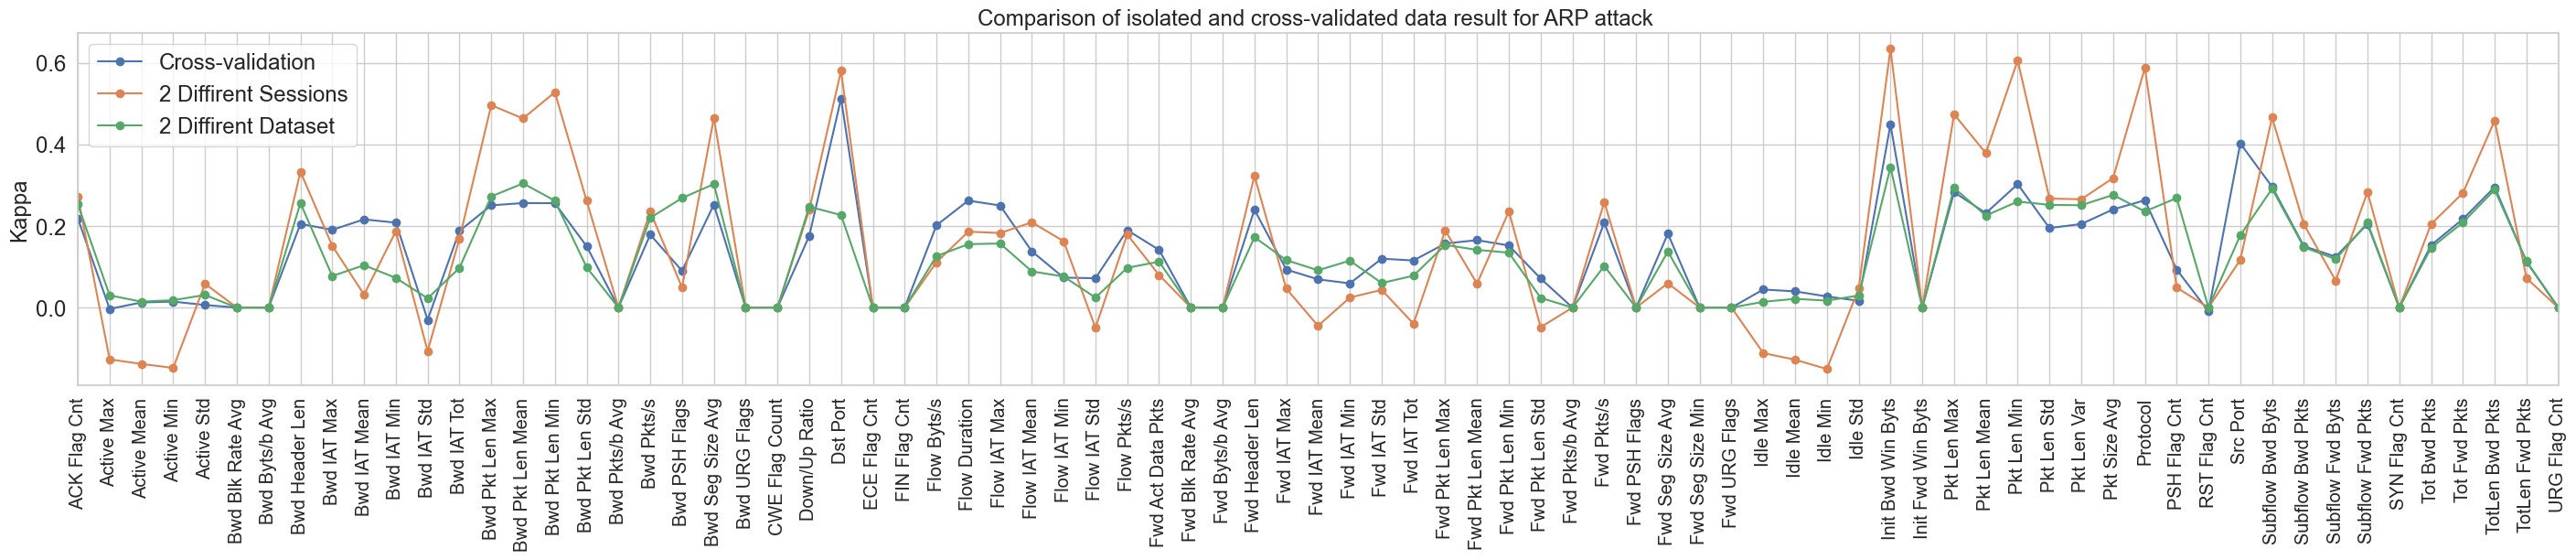

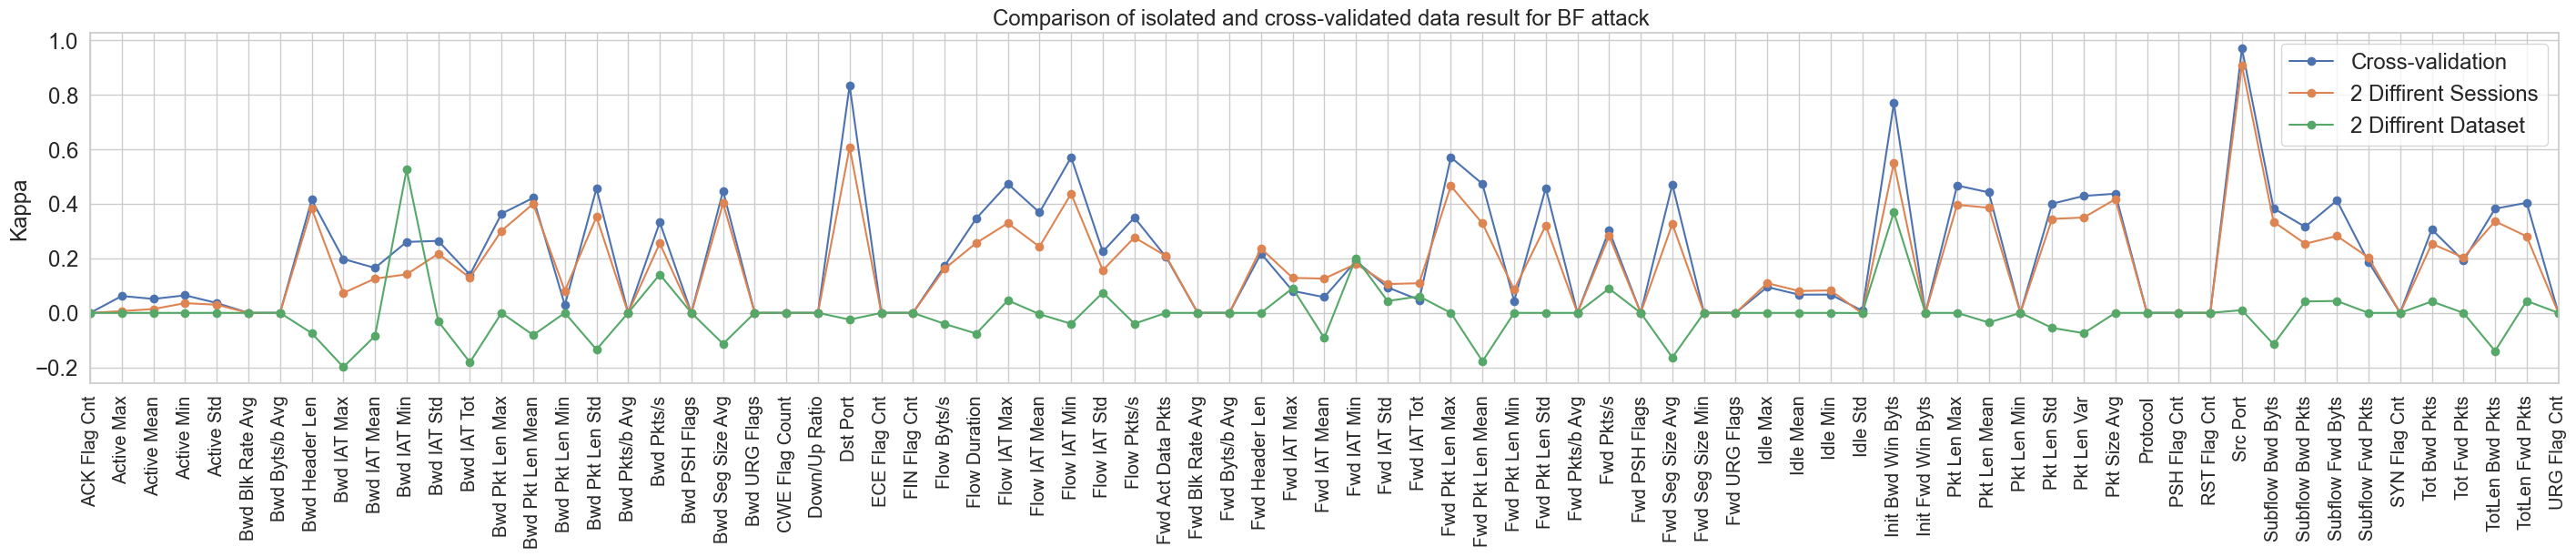

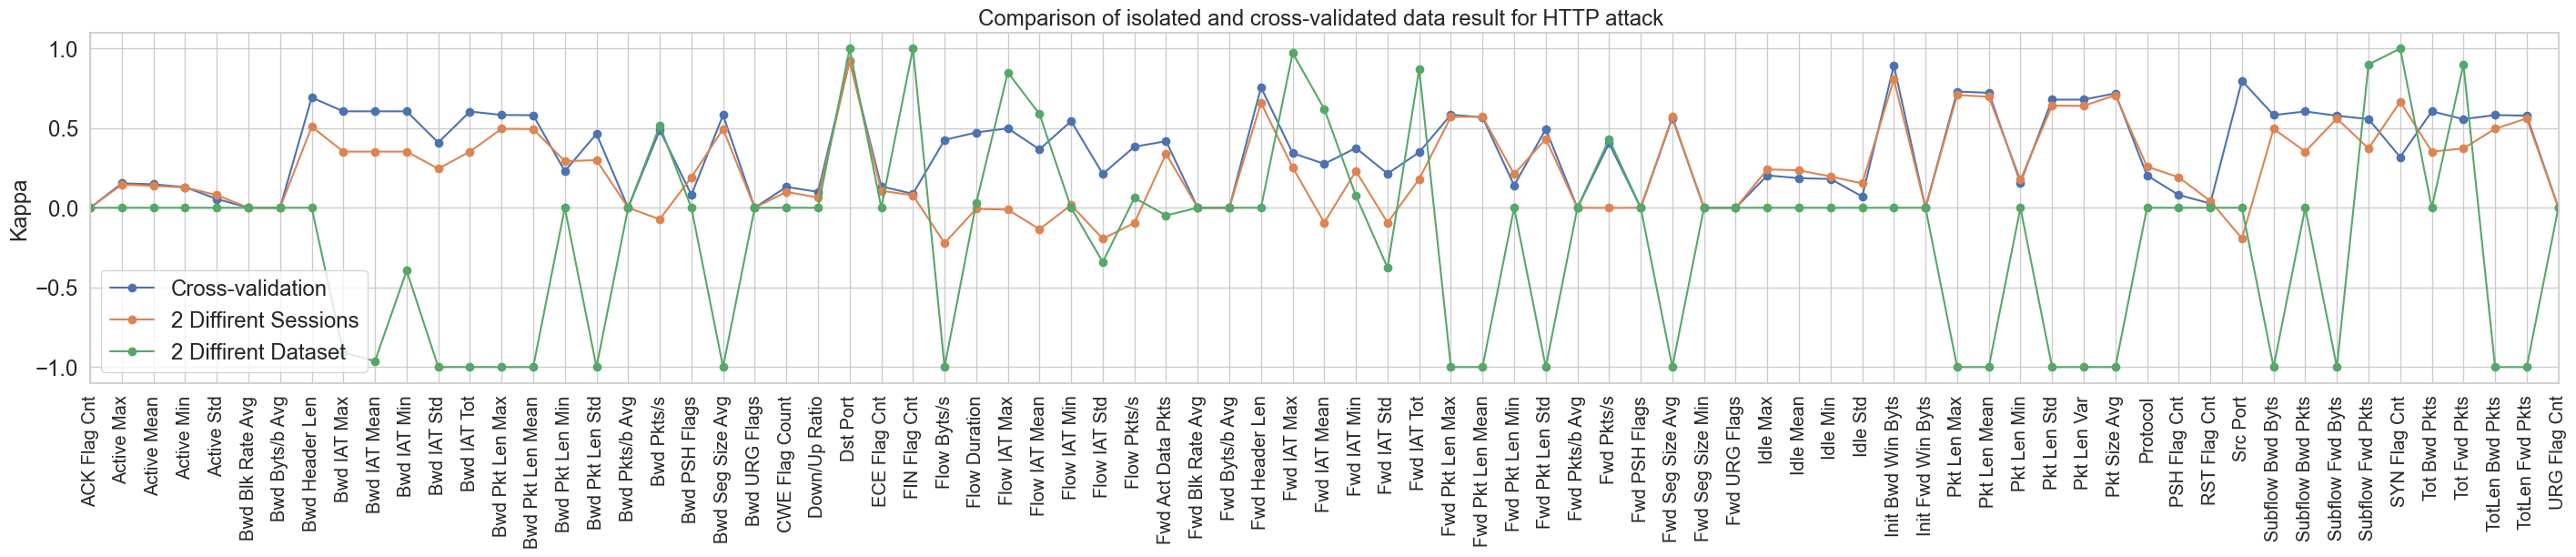

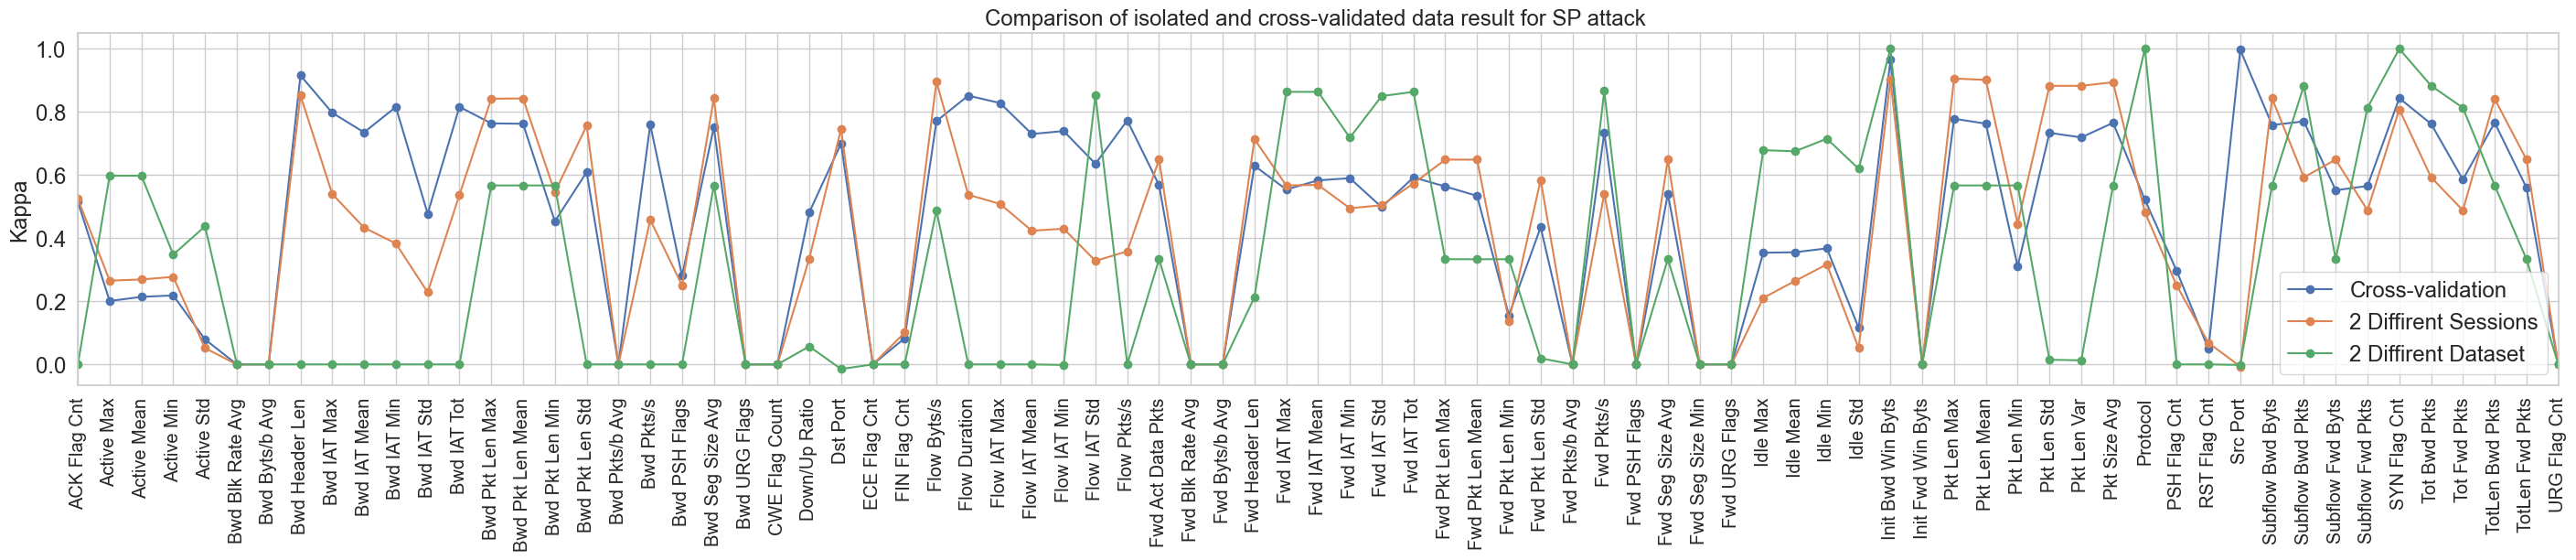

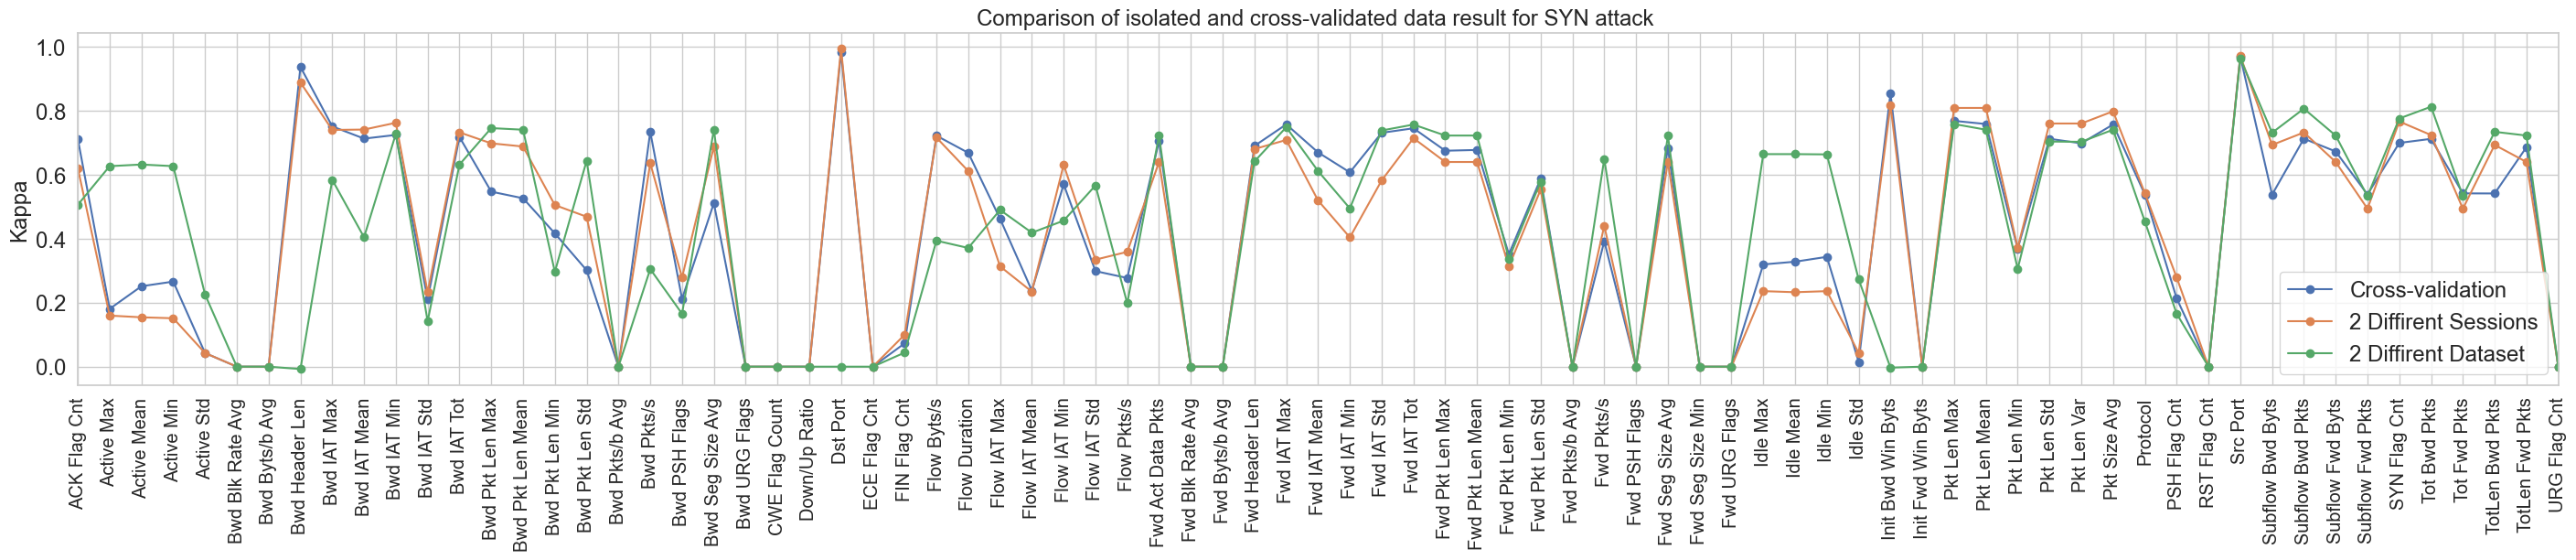

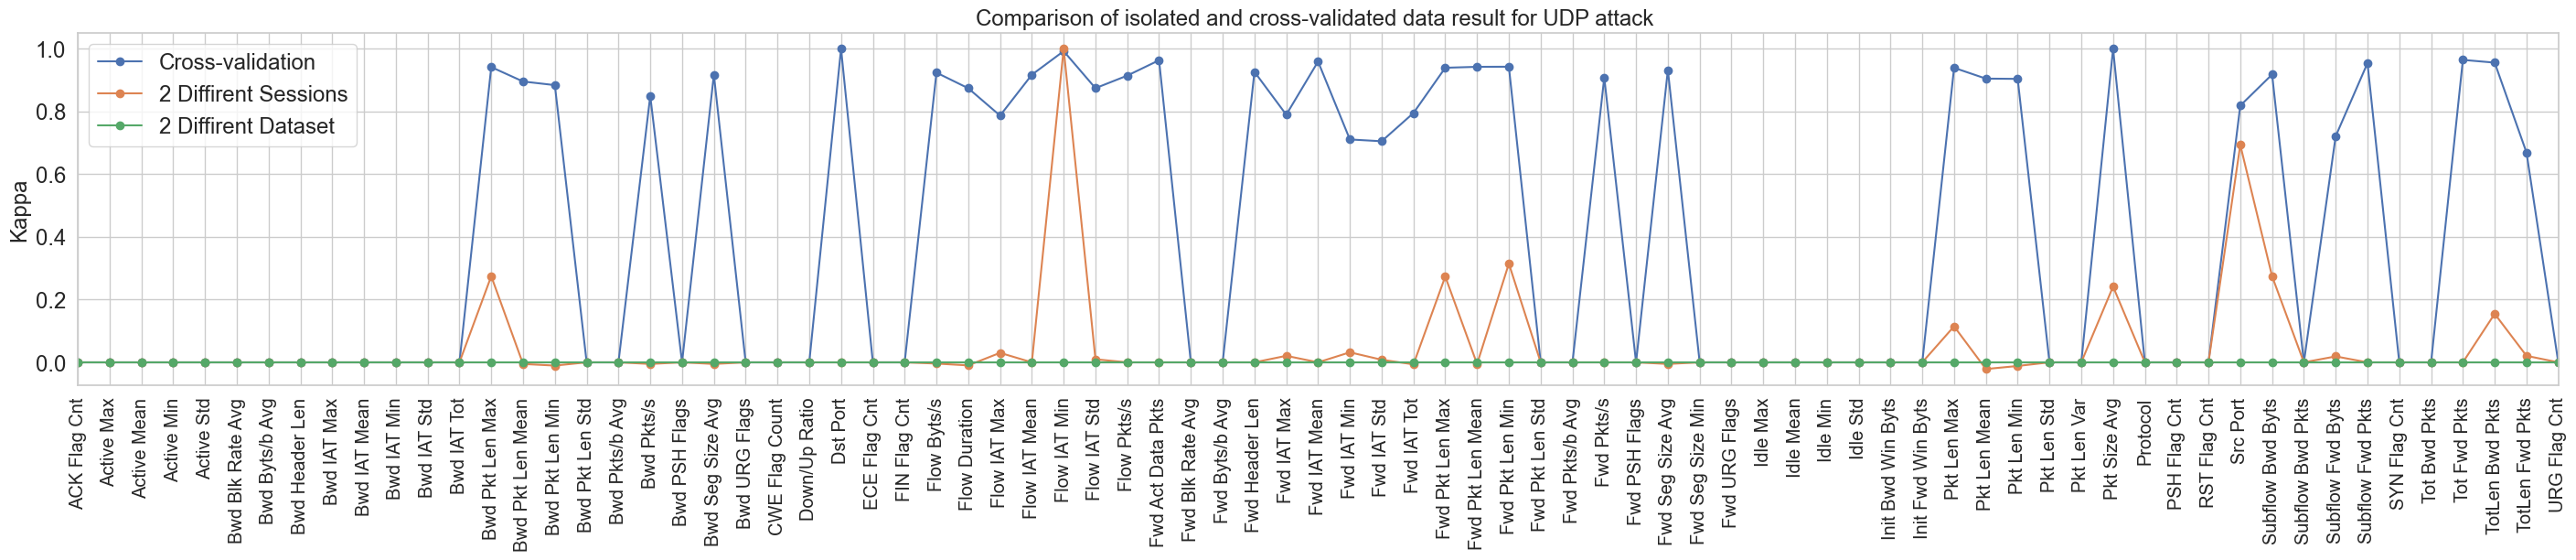

In [ ]:
method={"CV":"Cross-validation","SS":"2 Diffirent Sessions","DD":"2 Diffirent Dataset" }
import matplotlib.pylab as pylab
sns.set_style("whitegrid")
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (35, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'x-large'}
for i in results["Feature"].unique():    
    graph_name=f"./pdfs/Comparison_kappa_{i}.pdf"
    plt.margins(x=0)
    temp=[]
    df=results[results["Feature"]==i]
    for ii in results["Folder"].unique():
        sf=df[df["Folder"]==ii]
        my_xticks=sf["Attack"]#list(iso.index)
        pylab.rcParams.update(params)
        temp.append(sf['kap'].values)
        #plt.figure(figsize=(10,10))
        #plt.plot(my_xticks,iso['Acc'], linestyle='--', marker='.', color='b',label= "Separate Train & Test acc")
        #plt.plot(my_xticks,cv['Acc'], linestyle='--', marker='.', color='r',label= "10-Fold CV acc")
        plt.plot(my_xticks,sf['kap'], linestyle='-', marker='o',label= method[ii])
    #plt.plot(my_xticks,iso[' F1-score'], linestyle='-', marker='o', color='m',label= "Diffirent Dataset Isolated")
    #plt.plot(my_xticks,cv[' F1-score'], linestyle='-', marker='o', color='b',label= "5-Fold CV")
    #plt.axhline(0.492885, color='r',label= "Primary feature list")
    #plt.axhline(0.443367, color='r',label= "Primary feature list")
    plt.title(f"Comparison of isolated and cross-validated data result for {i} attack ")
    plt.legend(numpoints=1)
    #plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.ylabel("Kappa")
    plt.xticks(rotation=90) 
    #plt.ylim([0.69, 0.71]) 
    plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)
    plt.show()
    

In [ ]:
IDF=[
'DNS_id',
'TCP_seq',
'Ether_dst','ICMP_chksum',
'ICMP_id',"IP_len",  
"pck_size",
'ICMP_seq',
'ICMP_unused',
'ID',
'IP_chksum',
'IP_dst',
"random",
'IP_id',
'IP_src','TCP_ack',
'TCP_chksum',
'sport_bare',
'dport_bare',
'dport23',
'sport23',
'dport',
'sport']
     
# 'sum',
#'TCP_ACK_sum',
#'TCP_CWR_sum',
#'TCP_ECE_sum',
#'TCP_FIN_sum',
#'TCP_PSH_sum',
#'TCP_RST_sum',
#'TCP_SYN_sum',
#'TCP_URG_sum',
#'UDP_chksum']

In [ ]:
GA_input={}

____________________________________ACK________________________________________________________
53
['ACK Flag Cnt', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd Seg Size Avg', 'Down/Up Ratio', 'Dst Port', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Src Port', 'Subflow Bwd Byts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subflow Fwd Pkts', 'SYN Flag Cnt', 'Tot Bwd Pkts', 'Tot Fwd Pkts', 'TotLen Bwd Pkts', 'TotLen Fwd Pkts', 'Label']


47
['ACK Flag Cnt', 'Activ

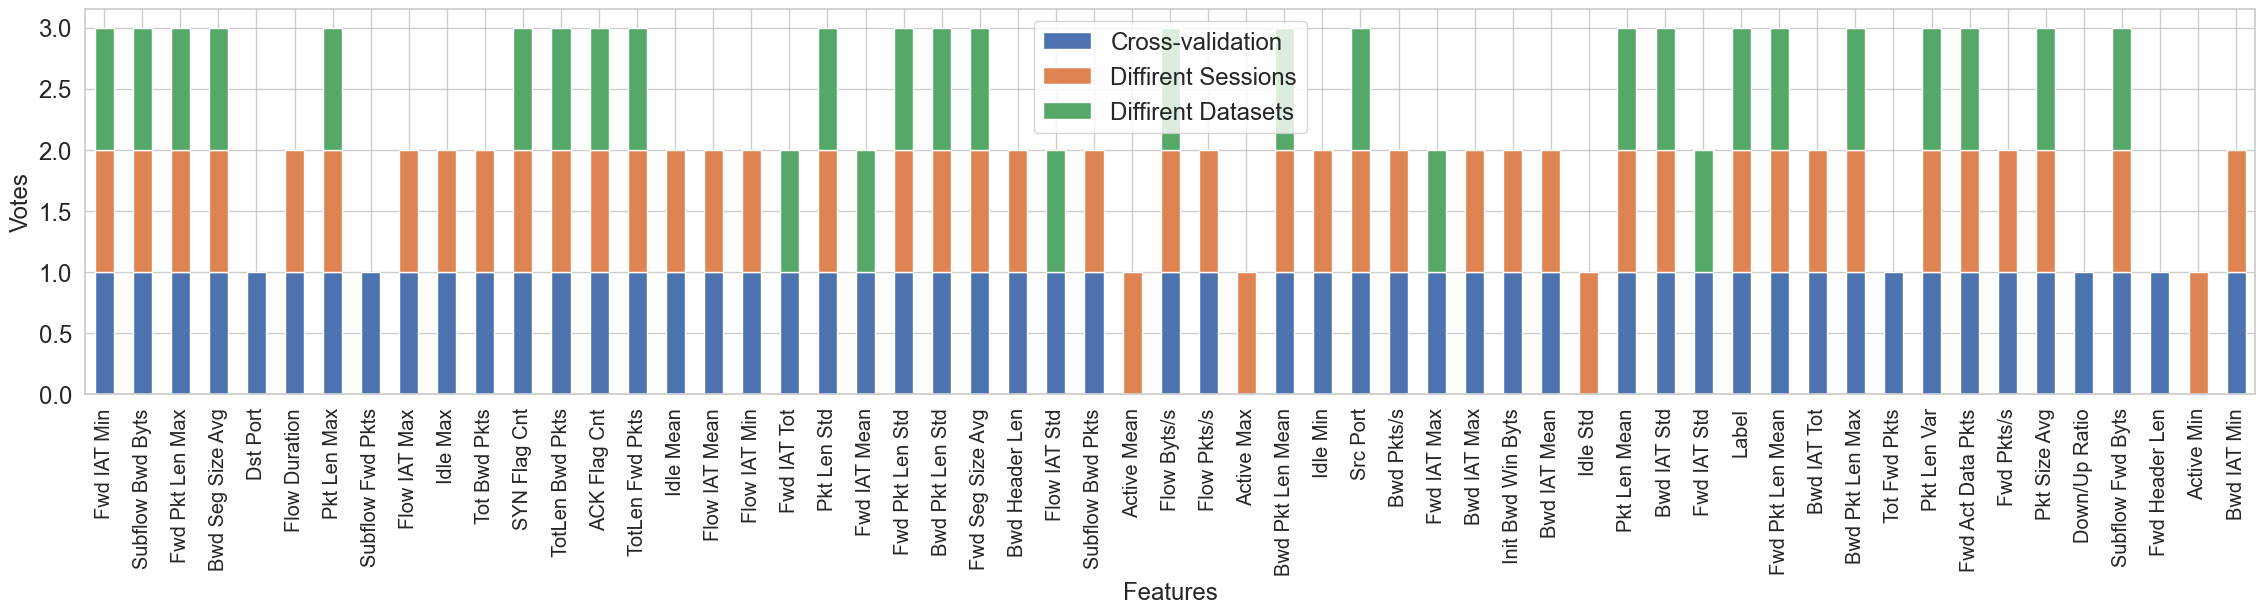

____________________________________ARP________________________________________________________
61
['ACK Flag Cnt', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd PSH Flags', 'Bwd Seg Size Avg', 'Down/Up Ratio', 'Dst Port', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Protocol', 'PSH Flag Cnt', 'Src Port', 'Subflow Bwd Byts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subf

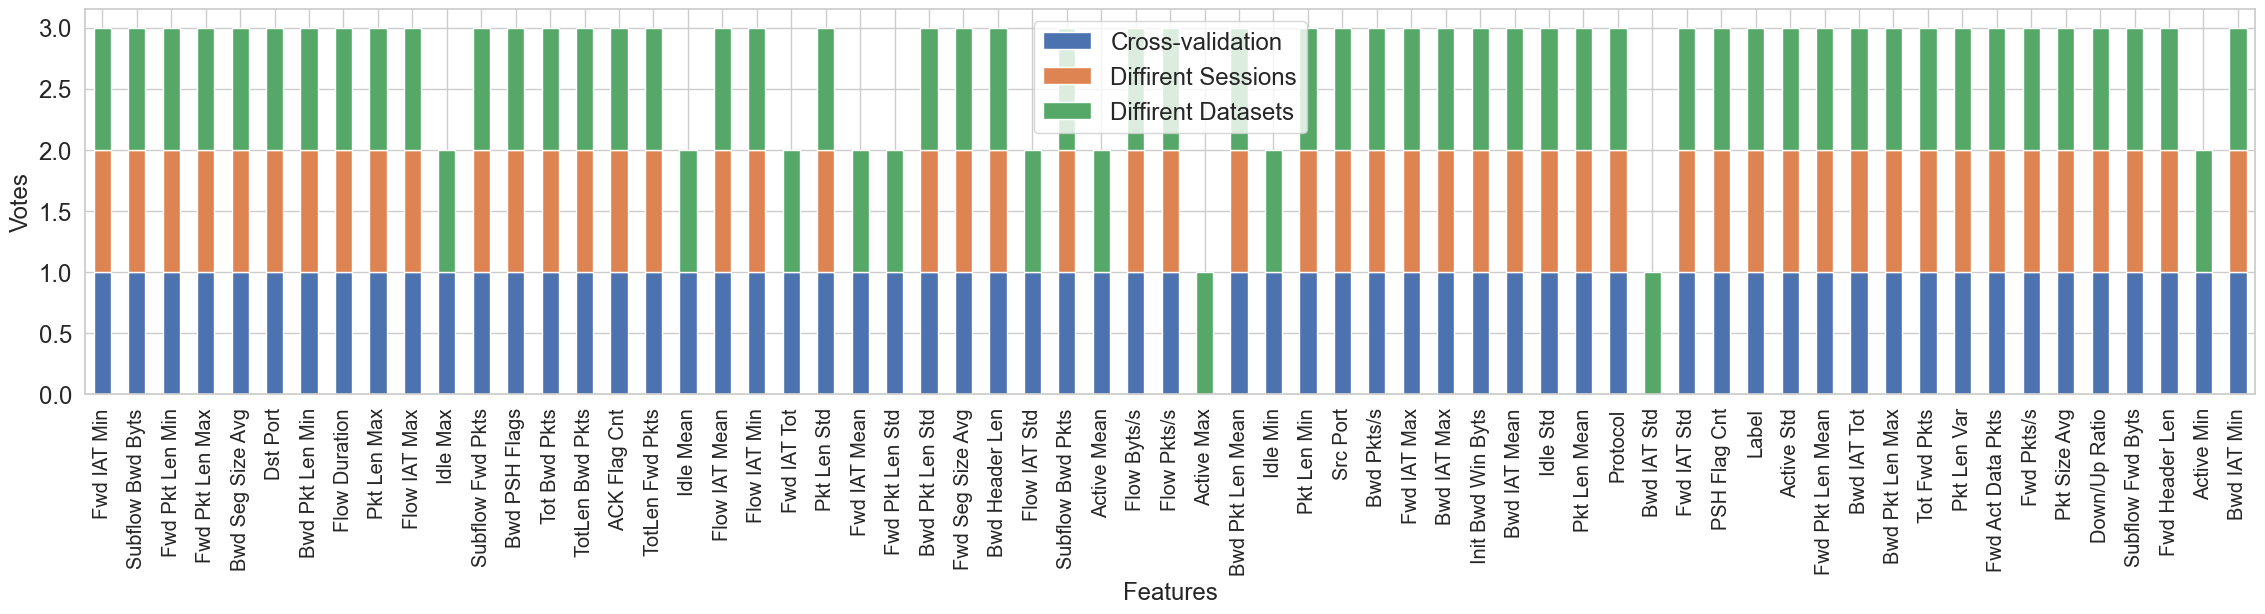

____________________________________BF________________________________________________________
57
['Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd Seg Size Avg', 'Dst Port', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Src Port', 'Subflow Bwd Byts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subflow Fwd Pkts', 'Tot Bwd Pkts', 'Tot Fwd Pkts', 'TotLen Bwd Pkts',

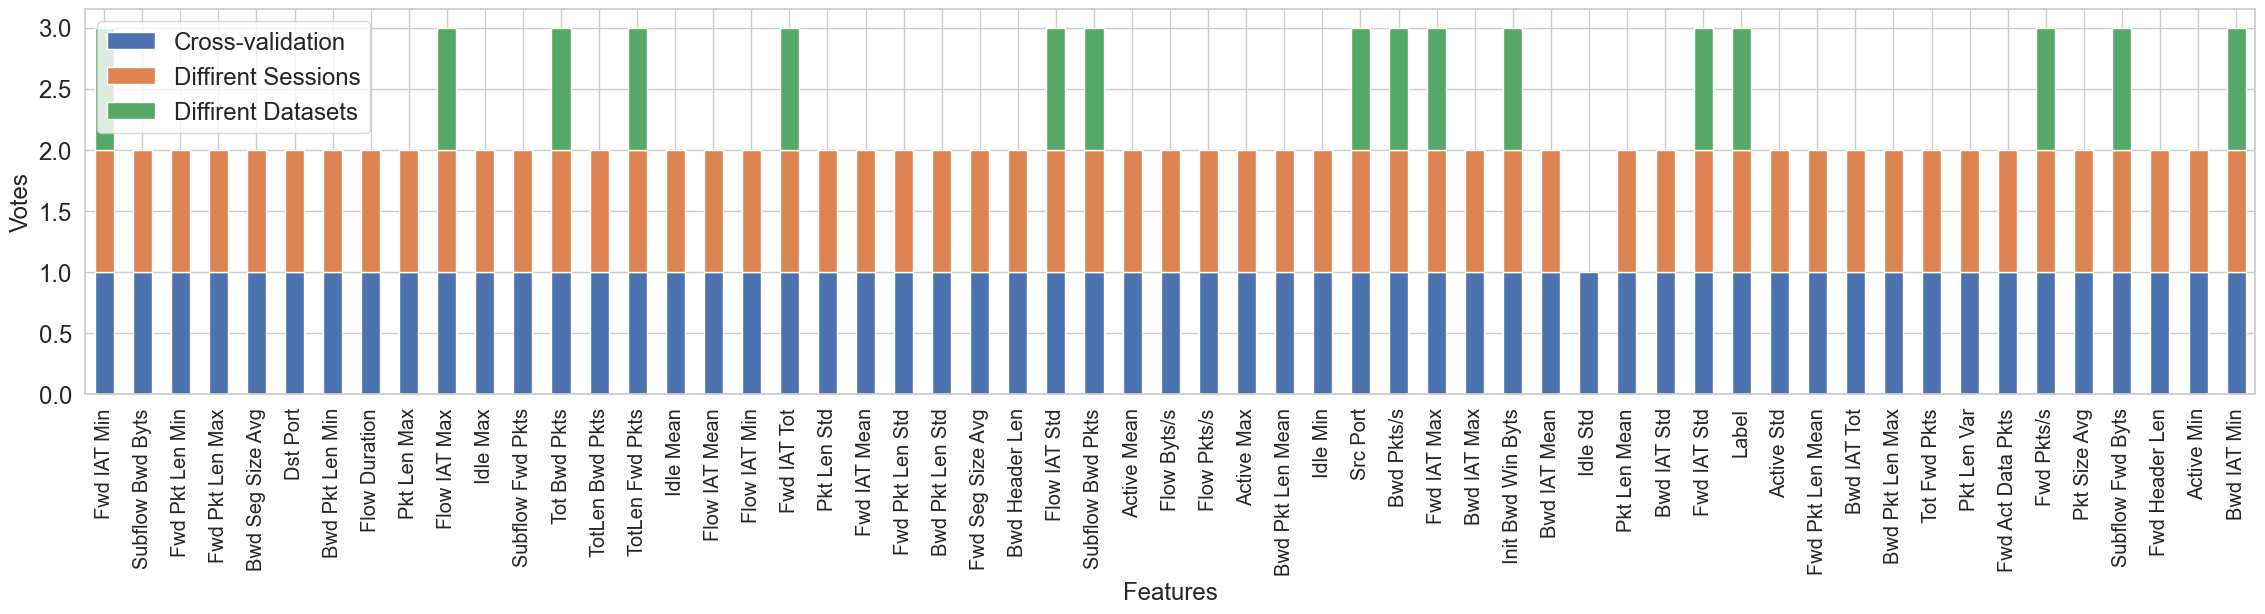

____________________________________HTTP________________________________________________________
67
['Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd PSH Flags', 'Bwd Seg Size Avg', 'CWE Flag Count', 'Down/Up Ratio', 'Dst Port', 'ECE Flag Cnt', 'FIN Flag Cnt', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Protocol', 'PSH Flag Cnt', 'RST Flag Cnt

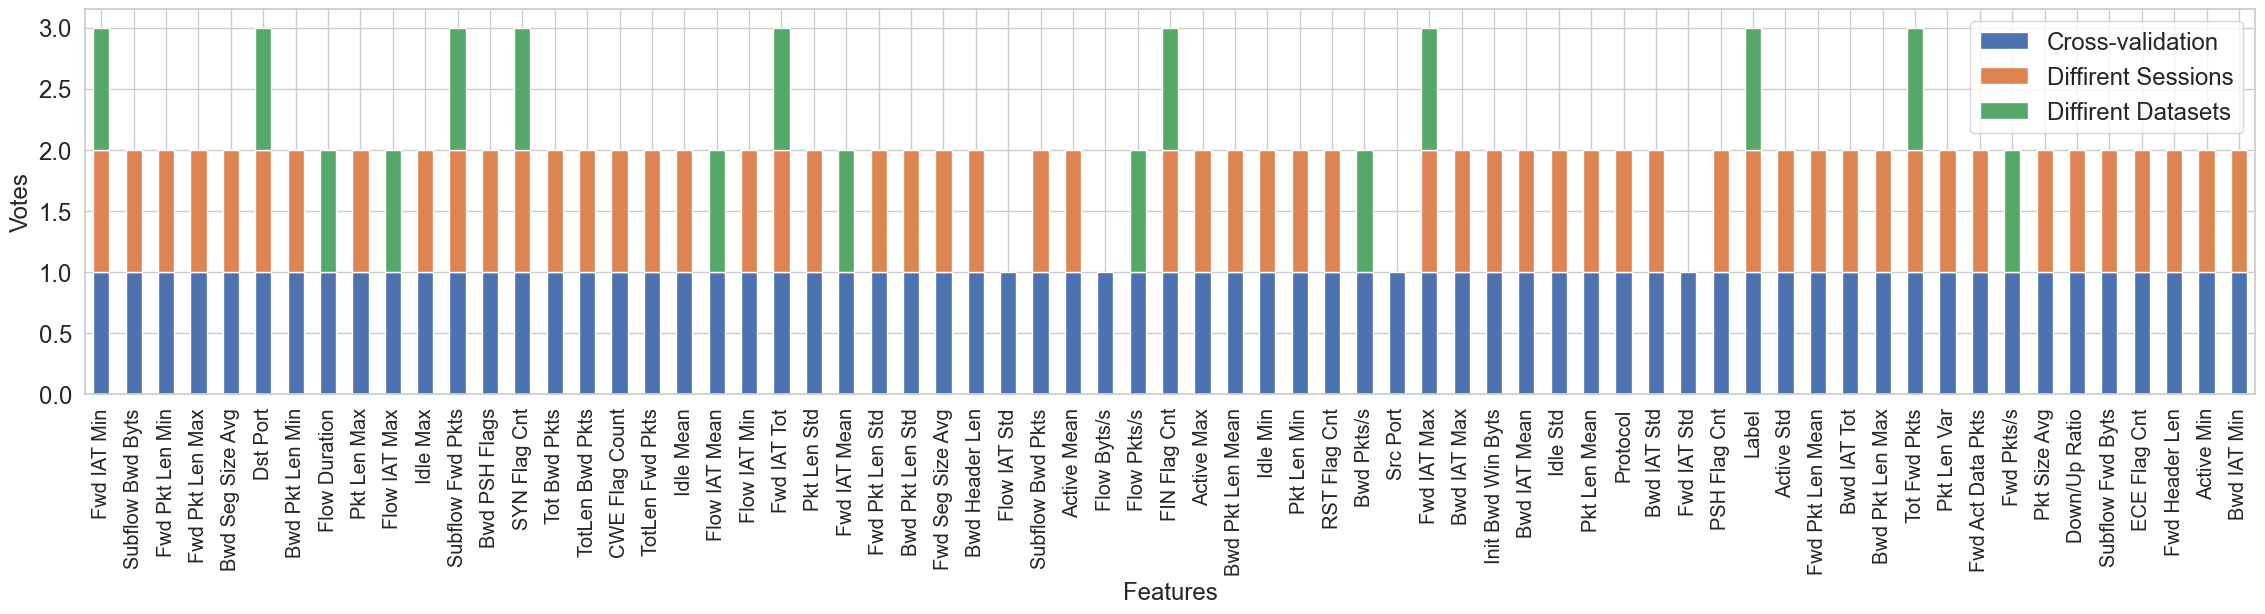

____________________________________SP________________________________________________________
66
['ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd PSH Flags', 'Bwd Seg Size Avg', 'Down/Up Ratio', 'Dst Port', 'FIN Flag Cnt', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Protocol', 'PSH Flag Cnt', 'RST Flag Cnt', 'Src Port', 'Subf

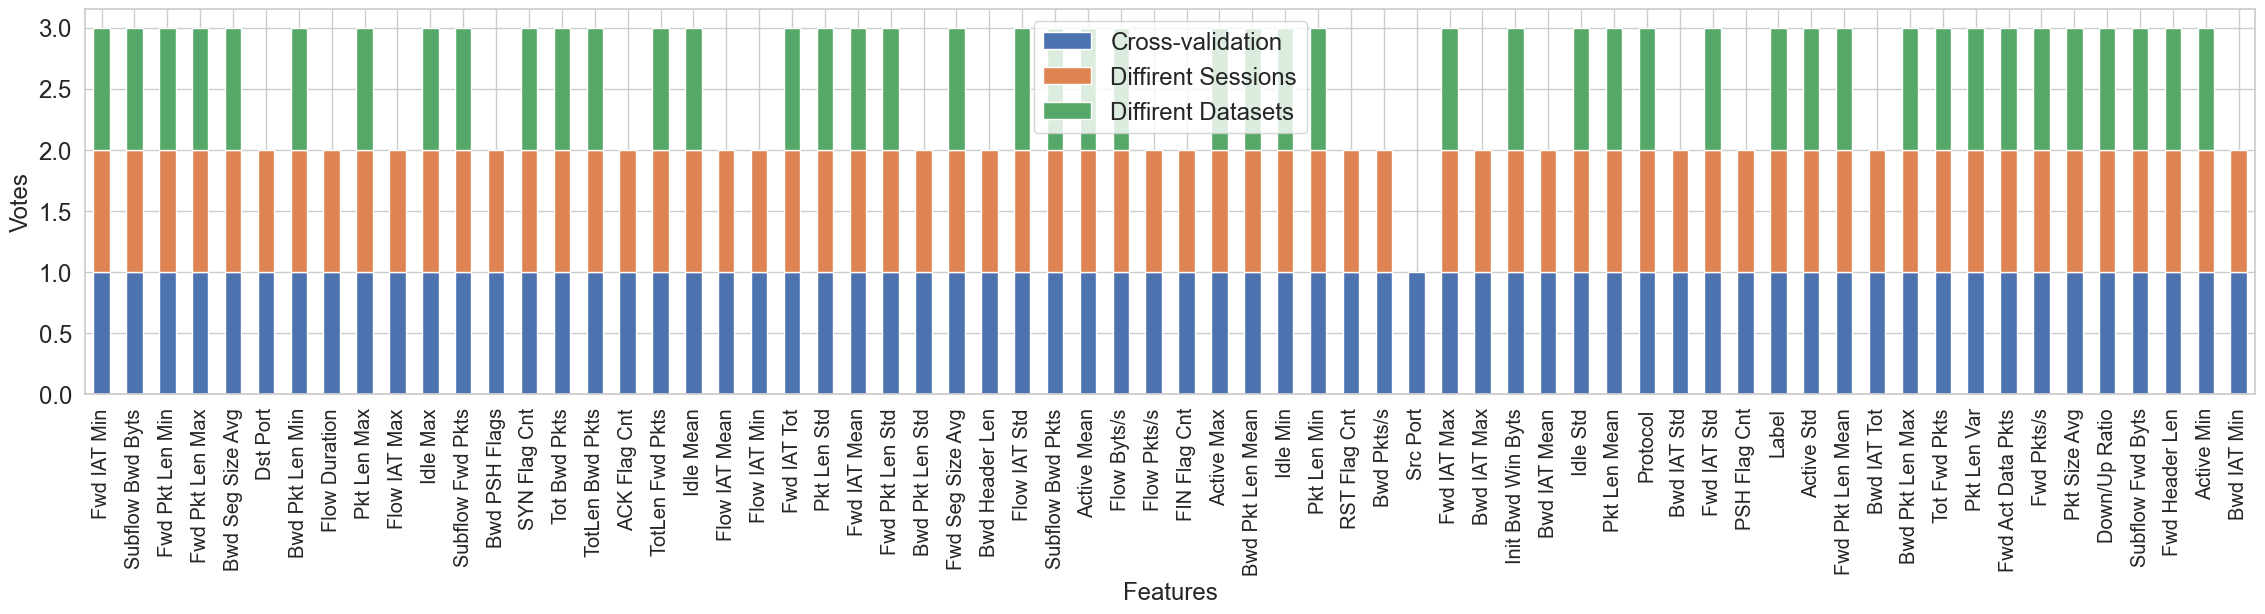

____________________________________SYN________________________________________________________
64
['ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd PSH Flags', 'Bwd Seg Size Avg', 'Dst Port', 'FIN Flag Cnt', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Protocol', 'PSH Flag Cnt', 'Src Port', 'Subflow Bwd Byts', 'Subflow Bwd Pkts

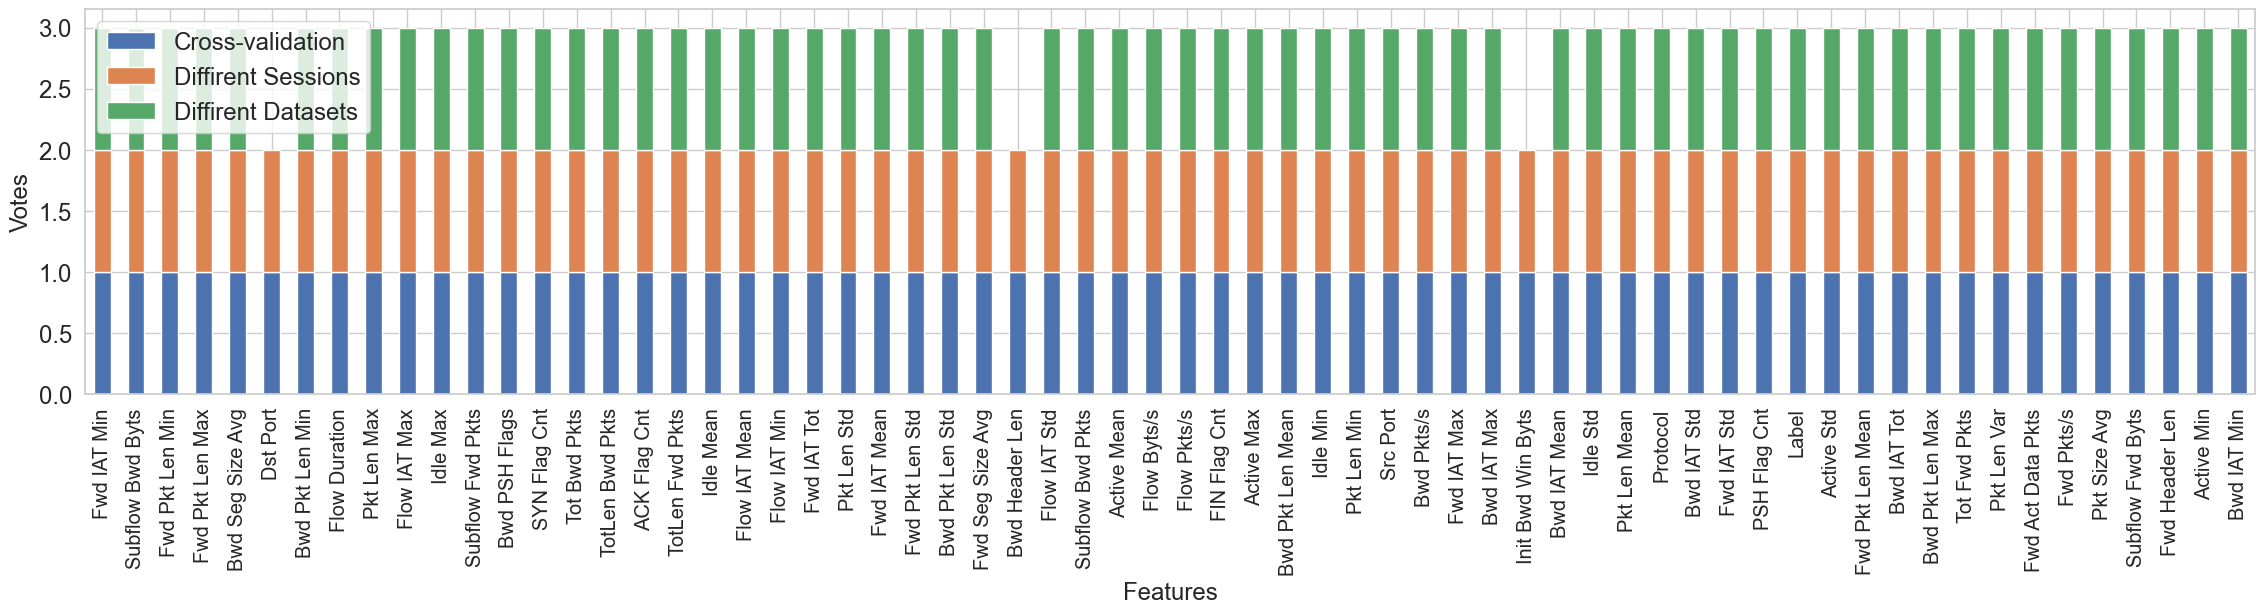

____________________________________UDP________________________________________________________
37
['Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkts/s', 'Bwd Seg Size Avg', 'Dst Port', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Min', 'Pkt Size Avg', 'Src Port', 'Subflow Bwd Byts', 'Subflow Fwd Byts', 'Subflow Fwd Pkts', 'Tot Fwd Pkts', 'TotLen Bwd Pkts', 'TotLen Fwd Pkts', 'Label']


17
['Bwd Pkt Len Max', 'Flow IAT Max', 'Flow IAT Min', 'Flow IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Pkt Len Max', 'Pkt Size Avg', 'Src Port', 'Subflow Bwd Byts', 'Subflow Fwd Byts', 'TotLen Bwd Pkts', 'TotLen Fwd Pkts', 'La

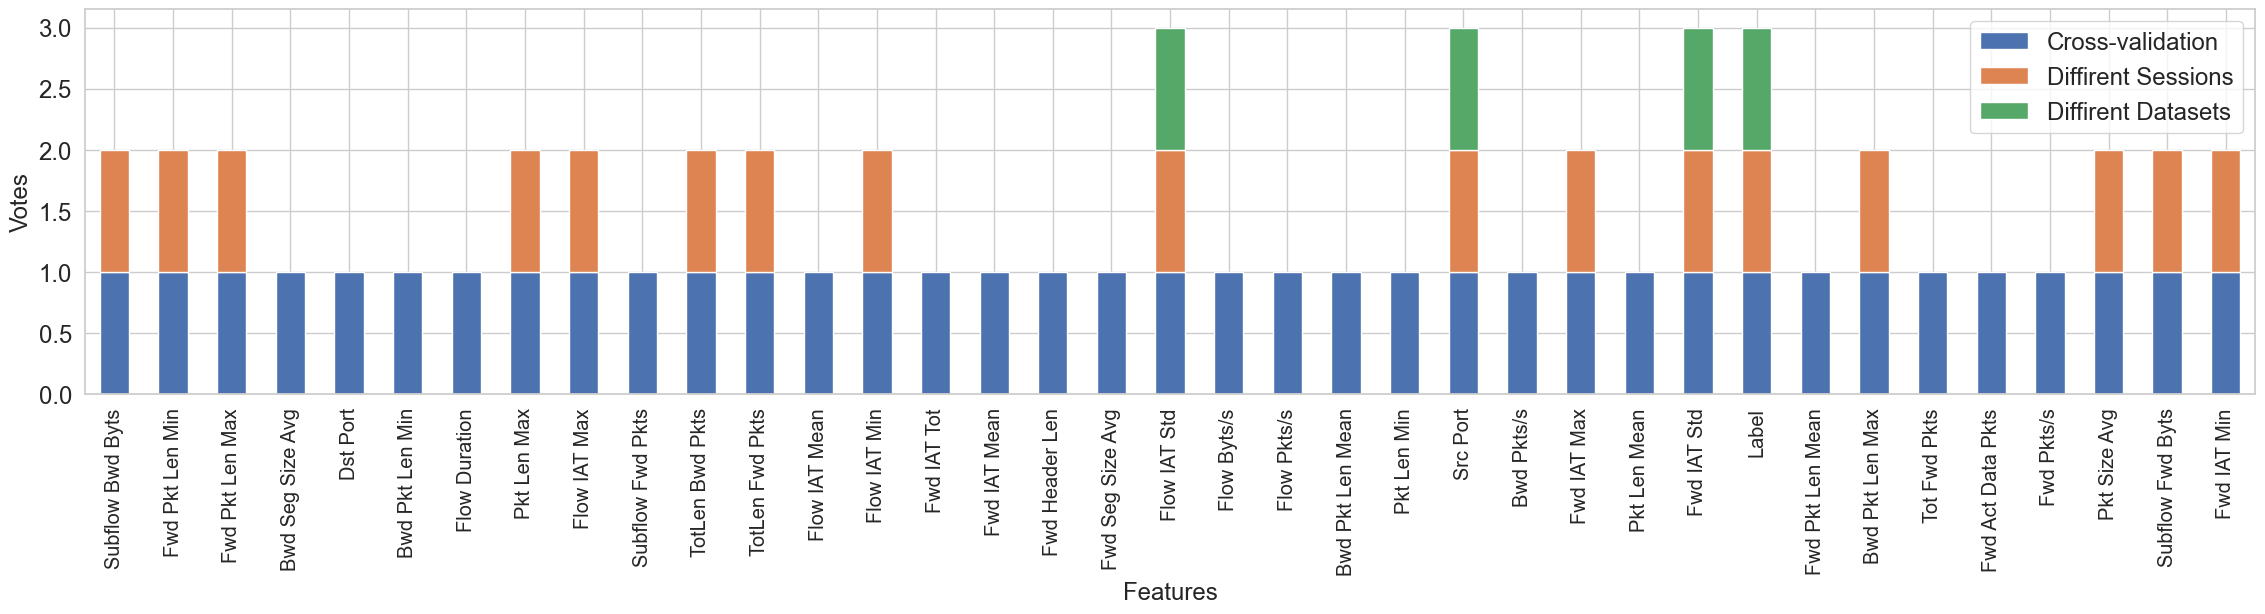

In [ ]:
method={"CV":"Cross-validation","SS":"2 Diffirent Sessions","DD":"2 Diffirent Dataset" }
import matplotlib.pylab as pylab
for attack in results["Feature"].unique():
    print(f"____________________________________{attack}________________________________________________________")
    #plt.margins(x=0)
    temp=[]
    df=results[results["Feature"]==attack]
    for ii in results["Folder"].unique():
        sf=df[df["Folder"]==ii]
        my_xticks=sf["Attack"]#list(iso.index)
        temp.append(sf['kap'].values)   
    itself=[]
    same=[]
    diff=[]
    my_xticks=my_xticks.values
    flag=1
    for j in range(len(temp[0])):
        if temp[0][j]>0:
            itself.append(my_xticks[j])
        if temp[1][j]>0:
            same.append(my_xticks[j])
        if temp[2][j]>0:
            diff.append(my_xticks[j])
    itself.append("Label")
    same.append("Label")
    diff.append("Label")
        
    for j in [itself,same]:
        print(len(j))
        print(f"{j}\n\n")
        
    merged=itself+same
    final_list=[]
    for d in diff:
        if d in merged:
            final_list.append(d)
            
    c1 = Counter(final_list)
    c2 = Counter(IDF)
    final_list = list((c1 - c2).elements())
    print(len(final_list))
    print(f"{final_list}\n\n")
    main=itself+same+diff
    GA_input[attack]=final_list
    main=set(main)
    mainlist=[]
    for i in main:
        temp=[i,int(i in itself),int(i in same),int(i in diff)]
        mainlist.append(temp)
    data=pd.DataFrame(mainlist, columns=["Feature", "Cross-validation","Diffirent Sessions","Diffirent Datasets"]).set_index('Feature')
    graph_name=f"./pdfs/kappa_{attack}_Voting2.PDF"
    import seaborn as sns
    sns.set_theme(style="whitegrid")

    plt.rcParams.update(params)
    import matplotlib.pylab as pylab

    #pylab.rcParams.update(params)

    data.plot.bar(stacked=True,figsize=(28,5))
    plt.xlabel('Features')
    plt.ylabel('Votes')
    plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)
    plt.show()

In [ ]:
# GA_input={'ACK': ['ACK Flag Cnt',
#   'Bwd IAT Std',
#   'Bwd Pkt Len Max',
#   'Bwd Pkt Len Mean',
#   'Bwd Pkt Len Std',
#   'Bwd Seg Size Avg',
#   'Flow Byts/s',
#   'Flow IAT Std',
#   'Fwd Act Data Pkts',
#   'Fwd IAT Max',
#   'Fwd IAT Mean',
#   'Fwd IAT Min',
#   'Fwd IAT Std',
#   'Fwd IAT Tot',
#   'Fwd Pkt Len Max',
#   'Fwd Pkt Len Mean',
#   'Fwd Pkt Len Std',
#   'Fwd Seg Size Avg',
#   'Pkt Len Max',
#   'Pkt Len Mean',
#   'Pkt Len Std',
#   'Pkt Len Var',
#   'Pkt Size Avg',
#   'Src Port',
#   'Subflow Bwd Byts',
#   'Subflow Fwd Byts',
#   'SYN Flag Cnt',
#   'TotLen Bwd Pkts',
#   'TotLen Fwd Pkts',
#   'Label'],
#  'ARP': ['ACK Flag Cnt',
#   'Active Mean',
#   'Active Min',
#   'Active Std',
#   'Bwd Header Len',
#   'Bwd IAT Max',
#   'Bwd IAT Mean',
#   'Bwd IAT Min',
#   'Bwd IAT Tot',
#   'Bwd Pkt Len Max',
#   'Bwd Pkt Len Mean',
#   'Bwd Pkt Len Min',
#   'Bwd Pkt Len Std',
#   'Bwd Pkts/s',
#   'Bwd PSH Flags',
#   'Bwd Seg Size Avg',
#   'Down/Up Ratio',
#   'Dst Port',
#   'Flow Byts/s',
#   'Flow Duration',
#   'Flow IAT Max',
#   'Flow IAT Mean',
#   'Flow IAT Min',
#   'Flow IAT Std',
#   'Flow Pkts/s',
#   'Fwd Act Data Pkts',
#   'Fwd Header Len',
#   'Fwd IAT Max',
#   'Fwd IAT Mean',
#   'Fwd IAT Min',
#   'Fwd IAT Std',
#   'Fwd IAT Tot',
#   'Fwd Pkt Len Max',
#   'Fwd Pkt Len Mean',
#   'Fwd Pkt Len Min',
#   'Fwd Pkt Len Std',
#   'Fwd Pkts/s',
#   'Fwd Seg Size Avg',
#   'Idle Max',
#   'Idle Mean',
#   'Idle Min',
#   'Idle Std',
#   'Init Bwd Win Byts',
#   'Pkt Len Max',
#   'Pkt Len Mean',
#   'Pkt Len Min',
#   'Pkt Len Std',
#   'Pkt Len Var',
#   'Pkt Size Avg',
#   'Protocol',
#   'PSH Flag Cnt',
#   'Src Port',
#   'Subflow Bwd Byts',
#   'Subflow Bwd Pkts',
#   'Subflow Fwd Byts',
#   'Subflow Fwd Pkts',
#   'Tot Bwd Pkts',
#   'Tot Fwd Pkts',
#   'TotLen Bwd Pkts',
#   'TotLen Fwd Pkts',
#   'Label'],
#  'BF': ['Bwd IAT Min',
#   'Bwd Pkts/s',
#   'Flow IAT Max',
#   'Flow IAT Std',
#   'Fwd IAT Max',
#   'Fwd IAT Min',
#   'Fwd IAT Std',
#   'Fwd IAT Tot',
#   'Fwd Pkts/s',
#   'Init Bwd Win Byts',
#   'Src Port',
#   'Subflow Bwd Pkts',
#   'Subflow Fwd Byts',
#   'Tot Bwd Pkts',
#   'TotLen Fwd Pkts',
#   'Label'],
#  'HTTP': ['Bwd Pkts/s',
#   'Dst Port',
#   'FIN Flag Cnt',
#   'Flow Duration',
#   'Flow IAT Max',
#   'Flow IAT Mean',
#   'Flow Pkts/s',
#   'Fwd IAT Max',
#   'Fwd IAT Mean',
#   'Fwd IAT Min',
#   'Fwd IAT Tot',
#   'Fwd Pkts/s',
#   'Subflow Fwd Pkts',
#   'SYN Flag Cnt',
#   'Tot Fwd Pkts',
#   'Label'],
#  'SP': ['Active Max',
#   'Active Mean',
#   'Active Min',
#   'Active Std',
#   'Bwd Pkt Len Max',
#   'Bwd Pkt Len Mean',
#   'Bwd Pkt Len Min',
#   'Bwd Seg Size Avg',
#   'Down/Up Ratio',
#   'Flow Byts/s',
#   'Flow IAT Std',
#   'Fwd Act Data Pkts',
#   'Fwd Header Len',
#   'Fwd IAT Max',
#   'Fwd IAT Mean',
#   'Fwd IAT Min',
#   'Fwd IAT Std',
#   'Fwd IAT Tot',
#   'Fwd Pkt Len Max',
#   'Fwd Pkt Len Mean',
#   'Fwd Pkt Len Min',
#   'Fwd Pkt Len Std',
#   'Fwd Pkts/s',
#   'Fwd Seg Size Avg',
#   'Idle Max',
#   'Idle Mean',
#   'Idle Min',
#   'Idle Std',
#   'Init Bwd Win Byts',
#   'Pkt Len Max',
#   'Pkt Len Mean',
#   'Pkt Len Min',
#   'Pkt Len Std',
#   'Pkt Len Var',
#   'Pkt Size Avg',
#   'Protocol',
#   'Subflow Bwd Byts',
#   'Subflow Bwd Pkts',
#   'Subflow Fwd Byts',
#   'Subflow Fwd Pkts',
#   'SYN Flag Cnt',
#   'Tot Bwd Pkts',
#   'Tot Fwd Pkts',
#   'TotLen Bwd Pkts',
#   'TotLen Fwd Pkts',
#   'Label'],
#  'SYN': ['ACK Flag Cnt',
#   'Active Max',
#   'Active Mean',
#   'Active Min',
#   'Active Std',
#   'Bwd IAT Max',
#   'Bwd IAT Mean',
#   'Bwd IAT Min',
#   'Bwd IAT Std',
#   'Bwd IAT Tot',
#   'Bwd Pkt Len Max',
#   'Bwd Pkt Len Mean',
#   'Bwd Pkt Len Min',
#   'Bwd Pkt Len Std',
#   'Bwd Pkts/s',
#   'Bwd PSH Flags',
#   'Bwd Seg Size Avg',
#   'FIN Flag Cnt',
#   'Flow Byts/s',
#   'Flow Duration',
#   'Flow IAT Max',
#   'Flow IAT Mean',
#   'Flow IAT Min',
#   'Flow IAT Std',
#   'Flow Pkts/s',
#   'Fwd Act Data Pkts',
#   'Fwd Header Len',
#   'Fwd IAT Max',
#   'Fwd IAT Mean',
#   'Fwd IAT Min',
#   'Fwd IAT Std',
#   'Fwd IAT Tot',
#   'Fwd Pkt Len Max',
#   'Fwd Pkt Len Mean',
#   'Fwd Pkt Len Min',
#   'Fwd Pkt Len Std',
#   'Fwd Pkts/s',
#   'Fwd Seg Size Avg',
#   'Idle Max',
#   'Idle Mean',
#   'Idle Min',
#   'Idle Std',
#   'Pkt Len Max',
#   'Pkt Len Mean',
#   'Pkt Len Min',
#   'Pkt Len Std',
#   'Pkt Len Var',
#   'Pkt Size Avg',
#   'Protocol',
#   'PSH Flag Cnt',
#   'Src Port',
#   'Subflow Bwd Byts',
#   'Subflow Bwd Pkts',
#   'Subflow Fwd Byts',
#   'Subflow Fwd Pkts',
#   'SYN Flag Cnt',
#   'Tot Bwd Pkts',
#   'Tot Fwd Pkts',
#   'TotLen Bwd Pkts',
#   'TotLen Fwd Pkts',
#   'Label'],
#  'UDP': ['Bwd Pkt Len Max', 'Flow IAT Max', 'Flow IAT Min', 'Flow IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Pkt Len Max', 'Pkt Size Avg', 'Src Port', 'Subflow Bwd Byts', 'Subflow Fwd Byts', 'TotLen Bwd Pkts', 'TotLen Fwd Pkts', 'Label']}

In [ ]:
import json
with open('GA_input.json', 'w') as fp:
    json.dump(GA_input, fp)

In [ ]:
GA_input

{'ACK': ['ACK Flag Cnt',
  'Bwd IAT Std',
  'Bwd Pkt Len Max',
  'Bwd Pkt Len Mean',
  'Bwd Pkt Len Std',
  'Bwd Seg Size Avg',
  'Flow Byts/s',
  'Flow IAT Std',
  'Fwd Act Data Pkts',
  'Fwd IAT Max',
  'Fwd IAT Mean',
  'Fwd IAT Min',
  'Fwd IAT Std',
  'Fwd IAT Tot',
  'Fwd Pkt Len Max',
  'Fwd Pkt Len Mean',
  'Fwd Pkt Len Std',
  'Fwd Seg Size Avg',
  'Pkt Len Max',
  'Pkt Len Mean',
  'Pkt Len Std',
  'Pkt Len Var',
  'Pkt Size Avg',
  'Src Port',
  'Subflow Bwd Byts',
  'Subflow Fwd Byts',
  'SYN Flag Cnt',
  'TotLen Bwd Pkts',
  'TotLen Fwd Pkts',
  'Label'],
 'ARP': ['ACK Flag Cnt',
  'Active Max',
  'Active Mean',
  'Active Min',
  'Active Std',
  'Bwd Header Len',
  'Bwd IAT Max',
  'Bwd IAT Mean',
  'Bwd IAT Min',
  'Bwd IAT Std',
  'Bwd IAT Tot',
  'Bwd Pkt Len Max',
  'Bwd Pkt Len Mean',
  'Bwd Pkt Len Min',
  'Bwd Pkt Len Std',
  'Bwd Pkts/s',
  'Bwd PSH Flags',
  'Bwd Seg Size Avg',
  'Down/Up Ratio',
  'Dst Port',
  'Flow Byts/s',
  'Flow Duration',
  'Flow IAT Max',
